# CÁLCULO DE LA INFORMACIÓN MUTUA ENTRE DOS SERIES TEMPORALES

**Autores**: Rafael Domínguez Sáez e Iñigo Martínez Ciriza

Octubre 2024

Máster en Ciencia de Datos

Universidad Autónoma de Madrid

## ÍNDICE

1. Introducción

2. Procesamiento de los datos

    2.1. Descarga de los datos a evaluar

    2.2. Preparación del entorno de ejecución
    
    2.3. Visualización de los datos

    2.4. Elección del umbral del potencial
    
3. Búsqueda del tamaño de ventana óptimo

    3.1. Búsqueda del tamaño de venta óptimo para los datos de control

    3.2. Búsqueda del tamaño de venta óptimo para los datos de reposo

4. Entropía, información mutua y transferencia de información

    4.1. Información mutua y transferencia de información para el tamaño de ventana óptimo

    4.2. Información mutua y transferencia de información en función del tamaño de ventana

5. Representación en SAX

## 1. INTRODUCCIÓN

En el presente trabajo, abordamos el estudio de la Información Mutua (`IM`) entre dos series temporales correspondientes a las neuronas VD y LP bajo diferentes condiciones experimentales: estado de control, inyección de GABA y recuperación del sistema. Nuestro objetivo principal es analizar cómo los eventos de tipo `spike` y `no spike` afectan al cálculo de probabilidades y, consecuentemente, a la estimación de la IM en estas series temporales.

El análisis se realiza utilizando palabras de un solo bit hasta 8 bits, evaluando cómo varía la Información Mutua en función del tamaño de la ventana temporal seleccionada. Además, estudiamos la transferencia de entropía entre las neuronas VD y LP en ambas direcciones, incorporando la entropía normalizada para una evaluación precisa de la dinámica de transferencia de información.

Finalmente, exploramos otros métodos de representación de los eventos, como los patrones de orden y la aproximación simbólica agregada `SAX`, con el fin de comparar las distintas maneras de calcular las probabilidades y su impacto en la estimación de la IM. Estos análisis nos permitirán comprender mejor la complejidad inherente en las series temporales y cómo las distintas técnicas capturan dicha complejidad.

## 2. PROCESAMIENTO DE LOS DATOS

### 2.1. Descarga de los datos a evaluar

En caso de no poseer los datos de sobre los cuales se va a realizar la práctica siguiente, se puede ejecutar la siguiente celda que descargará automáticamente estos datos en la raíz del proyecto.

In [224]:
"""
!pip install gdown

# Solo ejecutar esta celda si no tienes las trazas de los datos

import gdown
import zipfile
import os

file_id = '1D1gExECJbpmKupMuTisrZ3_9NMBVkD49'
output = 'datos.zip'

gdown.download(f'https://drive.google.com/uc?export=download&id={file_id}', output, quiet=False)

with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall()

os.remove(output)
"""

"\n!pip install gdown\n\n# Solo ejecutar esta celda si no tienes las trazas de los datos\n\nimport gdown\nimport zipfile\nimport os\n\nfile_id = '1D1gExECJbpmKupMuTisrZ3_9NMBVkD49'\noutput = 'datos.zip'\n\ngdown.download(f'https://drive.google.com/uc?export=download&id={file_id}', output, quiet=False)\n\nwith zipfile.ZipFile(output, 'r') as zip_ref:\n    zip_ref.extractall()\n\nos.remove(output)\n"

### 2.2. Preparación del entorno de ejecución

Lo primero que se debe realizar es la importación de las librerías principales que se van a utilizar en la práctica.

Además, por comodidad a la hora de tratar los datos para la creación de este notebook, se ha optado por el uso de las siguientes dos funciones `save_object` y `load_boject` para no necesitar volver a realizar calculos previamente calculados.

In [225]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

np.random.seed(0)

In [226]:
def save_object(o, name):
    with open(name,'wb') as f:
        pickle.dump(o,f)
    
def load_object(name):
    with open(name,'rb') as f:
        return pickle.load(f)

### 2.3. Visualización de los datos

Para leer los datos de los ficheros proporcionados se va a utilizar la funión de `pandas` `read_csv`. Así los datos se leen como dataframes de `Python`. Las distintas características de cada uno de los archivos se encuentra en el fichero `InformaciónFicheros.txt` donde nos describe lo que representa cada una de las columnas de los datos la forma de los dataframes. De esta forma se puede observar que el trozo C (control) y el trozo R (recuperación) contienen dos columnas, LP y VD mientras que el trozo G (inyección de GABA) tiene una tercera columna T que representa el tiempo y la duración de las inyecciones de GABA tras la cuarta spike de VD.

Una vez hemos obtenido los datos para la práctica comenzaremos el estudio del trozo G y más adelante se realizará el mismo análisis para el resto de trozos. Así, leemos los datos y mostramos los 10 primeros elementos de cada columna del fichero `TrozoG.txt`.

In [227]:
trozoG = pd.read_csv("Datos/TrozoG.txt", names = ["LP", "VD","T"],
                     usecols = [0, 1, 2],
                     delimiter = "\t", skiprows = range(3), 
                     index_col = False, decimal = ",")

trozoG.head(10)

,LP,VD,T
0,-0.006104,0.064697,0.120239
1,-0.004272,0.075989,0.126343
2,-0.003357,0.087280,0.125427
3,-0.005188,0.092468,0.123596
4,-0.007324,0.093384,0.118713
5,-0.010681,0.089722,0.105896
6,-0.004883,0.086975,0.127258
7,0.004272,0.092468,0.111084
8,0.002441,0.087585,0.114136
9,0.003357,0.080872,0.110779


Podemos representar estos datos en función del tiempo sabiendo que cada señal se ha tomado cada milisegundo. Así, definimos una función `plot_data` que dado un intervalo de milisegundos, representa el valor del potencial medido para las columnas del dataframe de entrada. 

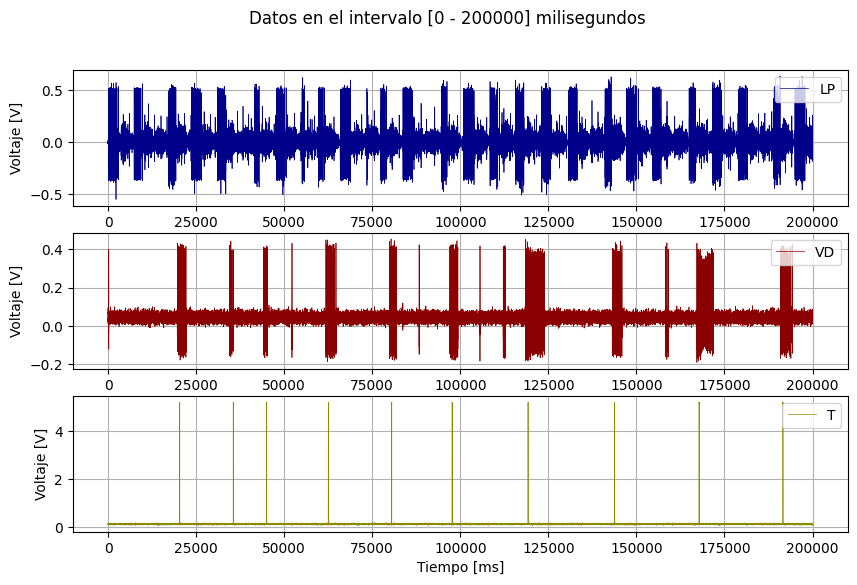

In [228]:
def plot_data(
        data: pd.DataFrame = None, 
        lines: list = None, 
        lines_titles: list = None, 
        x: list = [0, 10000]
    ):
    if data is None:
        raise ValueError("Data cannot be None")
    
    lines = [] if lines is None else lines
    lines_titles = [] if lines_titles is None else lines_titles

    cols = len(data.columns)
    if len(lines) > 0 and len(lines) != cols:
        raise ValueError(f"Incorrect number of lines given, sizes are {cols} and {len(lines)}")

    x_values = np.arange(x[0], x[1], 1)
    
    colors = ['#00008B', '#8B0000', '#8B8B00', '#000000']

    fig, axs = plt.subplots(cols, figsize=(10, 2 * cols))
    fig.suptitle('Datos en el intervalo [{} - {}] milisegundos'.format(x[0], x[1]))

    if cols == 1:
        axs = [axs]

    for i in range(cols):
        axs[i].plot(x_values, data.iloc[x[0]:x[1], i], 
                    label=data.columns[i], 
                    color=colors[i], 
                    linewidth=0.5)

        if len(lines) > 0:
            y_values = [lines[i] for _ in x_values]
            axs[i].plot(x_values, y_values, 
                        color=colors[-1], 
                        label=lines_titles[i] if len(lines_titles) > i else 'Line {}'.format(i), 
                        linestyle="--", 
                        linewidth=0.5)

        axs[i].legend(loc="upper right")
        axs[i].set_ylabel("Voltaje [V]")
        axs[i].set_xlabel("Tiempo [ms]")
        axs[i].grid(True)

plot_data(trozoG, x = [0,200000])

Gracias a esta representación, somos capaces de observar la forma general de las señales para conocer cuando ocurre una spike en nuestra neurona de estudio (VD o LP) o si la señal detectada proviene de una neurona que no nos interesa. De hecho, este caso es especialmente notable en la neurona LP donde la señal es bastante más inestable que la señal de la neurona VD (para el caso de este trozo). Esto se debe a que en esta neurona se reciben señales bastante fuertes de los spikes de otras neuronas, que se corresponden con los picos en el voltaje, no tan elevados observados en la primera figura.

### 2.4. Elección del umbral del potencial

Es por eso que el siguiente paso a determinar es el umbral en el voltaje a partir del cual consideraremos que la señal obtenida es una spike o cuando no lo será. Para realizar este filtro se pueden realizar una gran cantidad de métodos. En nuestro caso hemos decidido utilizar un histograma que nos permita representar las distintas poblaciones de sucesos: spikes de LP, spikes de otras neuronas detectadas en LP, spikes de VD, spikes de otras neuronas detectadas en VD y spikes en T.

El problema de la representación en histogramas es que discretizamos una función continua. Esto significa que en nuestro histograma aparecerán con bastante frecuencia valores de voltaje cercanos a 0, que son los spikes detectados pertenecientes a otras neuronas que no son la neurona LP o VD. Además, luego tendremos una parte de "meseta" en la que aparecerán con bastante frecuencia pero no tanta como antes los valores de los spikes de las neuronas de estudio. Esta población será digamos una meseta puesto que al discretizar una función continua, obtendremos datos de voltaje cuando comienza el spike, cuando empieza a subir considerablemente, cuando alcanza su máximo, cuando comienza a descender el potencial... es así como el conjunto de todos estos datos producirán una zona de frecuencias absolutas bastante altas.

Para obtener los histogramas definimos la siguiente función:

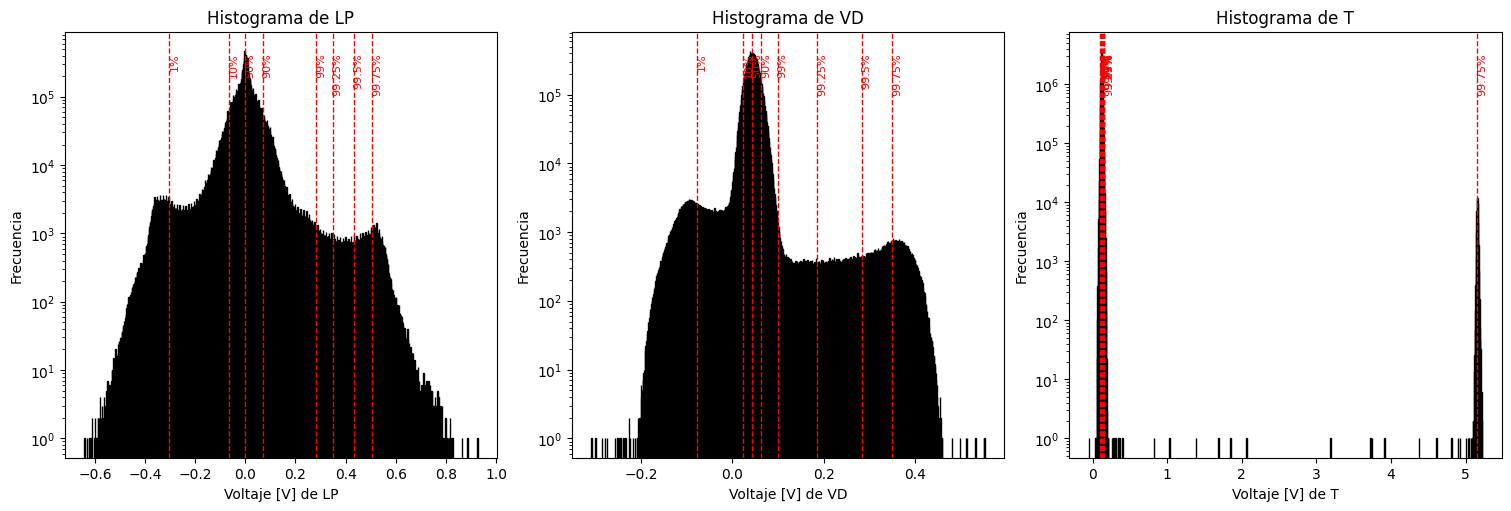

In [229]:
def plot_histograms_with_percentiles(df: pd.DataFrame, columns: list = ['LP', 'VD'], percentiles: list = [1, 10, 50, 90, 99, 99.25, 99.5, 99.75]):

    num_cols = len(columns)
    
    _, axs = plt.subplots(1, num_cols, figsize=(15, 5), constrained_layout=True)

    for i, col in enumerate(columns):
        deciles = np.percentile(df[col], percentiles)
        
        axs[i].hist(df[col], bins=1000, edgecolor='black')
        
        for decil, perc in zip(deciles, percentiles):
            axs[i].axvline(decil, color='red', linestyle='dashed', linewidth=1)
            axs[i].text(decil, axs[i].get_ylim()[1] * 0.9, f'{perc}%', 
                        rotation=90, verticalalignment='top', color='red', fontsize=8)
        
        axs[i].set_xlabel(f'Voltaje [V] de {col}')
        axs[i].set_ylabel('Frecuencia')
        axs[i].set_title(f'Histograma de {col}')
        axs[i].set_yscale('log')
    
    plt.show()

columns = ['LP', 'VD', 'T']
plot_histograms_with_percentiles(trozoG, columns)

Como se puede observar, se puede distinguir claramente en los dos casos una población muy frecuente de valores del voltaje centrada en 0 V. Esta es la mencionada población de señales de spikes de otras neuronas que no son las interesantes de estudio. Además, en ambos casos, aunque en VD aparece mejor distinguido, se muestra esta zona de meseta, correspondiente a los datos de subida y consecuente bajada de potencial de los spikes de las neuronas de intereés. En LP se distingue peor esta zona puesto que algunos spikes de neuronas fuera de nuestro estudio se superponen con los valores donde el valor del potencial del spike de LP comienza a subir y es por eso que el paso de la población de spikes de fondo a la zona de meseta es más suave que en VD.

Cabe destacar en estas zonas de meseta, se encuentra al final de las mismas un pico de aumento de la frecuencia de los datos, correspondiente al máximo de un spike de la neurona de estudio, ya sea VD o LP. Este aumento, centrado en LP en aproximadamente 0.5 V y centrada en VD en aproximadamente 0.35 V se corresponde con el máximo del spike de la neurona de estudio, donde se activan los canales de sodio y se abren los canales de potasio. Aumenta la frecuencia puesto que el voltaje se suaviza ya que se corresponde con el máximo de la spike y es por eso que resulta natural que aumente la frecuencia observada. Se muestra este comportamiento mejor en la imagen mostrada:

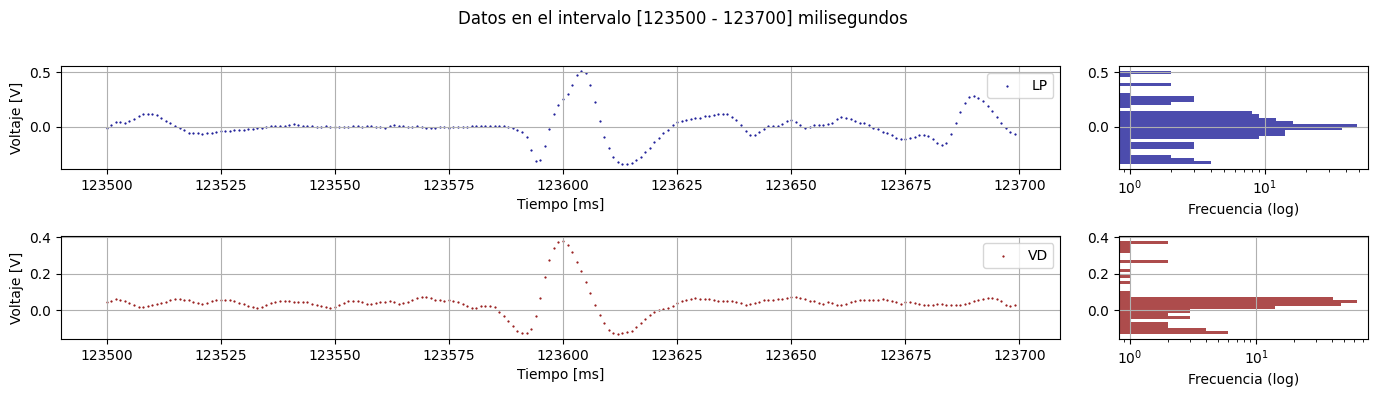

In [230]:
data = trozoG[['LP', 'VD']]
x = [123500, 123700]
lines = []
lines_titles = []

cols = len(data.columns)

x_values = np.arange(x[0], x[1], 1)

colors = ['#00008B', '#8B0000', '#8B8B00', '#000000']

fig, axs = plt.subplots(cols, 2, figsize=(14, 2 * cols), gridspec_kw={'width_ratios': [4, 1]})
fig.suptitle('Datos en el intervalo [{} - {}] milisegundos'.format(x[0], x[1]))

if cols == 1:
    axs = [axs]

for i in range(cols):
    # Gráfica de la función temporal
    axs[i][0].scatter(x_values, data.iloc[x[0]:x[1], i], 
                   label=data.columns[i], 
                   color=colors[i],
                   s = 0.3)

    # Añadir líneas opcionales, si existen
    if len(lines) > 0:
        y_values = [lines[i] for _ in x_values]
        axs[i][0].plot(x_values, y_values, 
                       color=colors[-1], 
                       label=lines_titles[i] if len(lines_titles) > i else 'Line {}'.format(i), 
                       linestyle=".", 
                       linewidth=0.5)

    axs[i][0].legend(loc="upper right")
    axs[i][0].set_ylabel("Voltaje [V]")
    axs[i][0].set_xlabel("Tiempo [ms]")
    axs[i][0].grid(True)

    # Histograma de frecuencias de los datos en escala logarítmica
    axs[i][1].hist(data.iloc[x[0]:x[1], i], bins=30, orientation="horizontal", color=colors[i], alpha=0.7, log=True)
    axs[i][1].set_xlabel("Frecuencia (log)")
    axs[i][1].grid(True)

# Ajustar el layout para evitar solapamientos
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

En vista de esta representación, es fácil entender la razón por la que existe un aumento de la frecuencia al final de la meseta y es que este aumento se corresponde con el máximo de los spikes ya que los puntos se acumulan. Además también nos permite entender el aumento de la frecuencia a la izquierda de los spikes de fondo, correspondientes al periodo de hiperpolarización en el que ocurre decrecimiento rápido del potencial por debajo del potencial de reposo. De esta forma, se pueden entender claramente los tres picos de frecuencia observados en el histograma superior. Además, la frecuncia del momento de voltaje por debajo del voltaje de reposo es mayor que la frecuencia del máximo de los spikes puesto que ocurre el doble de veces y por tanto, existen más puntos en estos eventos.

Es por ello que se ha decidido determinar como umbral de potencial a partir del cual consideremos que ocurre un spike al valor del potencial donde la frecuencia en esta zona de meseta comienza a ascender, puesto que se corresponde con el máximo de los spikes. Este comienzo del ascenso de la frecuencia nos permite además incluir a prácticamente todos los spikes puesto que los spikes de menor amplitud también son considerados y no únicamente aquellos con valores poblacionalmente más altos de potencial.

Es aquí donde entran los cuartiles representados que nos permiten visualizar la cantidad de datos que debemos escoger. Hemos representado una serie de líneas que representan estos cuartiles para observar a partir de qué valor vamos a considerar nuestro umbral. En vista de las poblaciones, se han escogido los percentiles: 99.5% para LD, 99.5% para VD y 99.7% para T pues es cuando la frecuencia comienza a aumentar y se cogen los spikes de las nueronas de estudio (para el caso de LP y VD).

Una vez hemos determinado estos valores, representaremos una línea que represente el umbral a partir del cual consideraremos que la señal es considerada un spike y a partir del cual lo descartaremos.

In [231]:
def get_percentiles(data: pd.DataFrame,
                    q: list = []
                    ):
    perc = data.quantile(q)
    return np.diag(perc)

Percentiles:
 [0.432129 0.282593 5.144653]


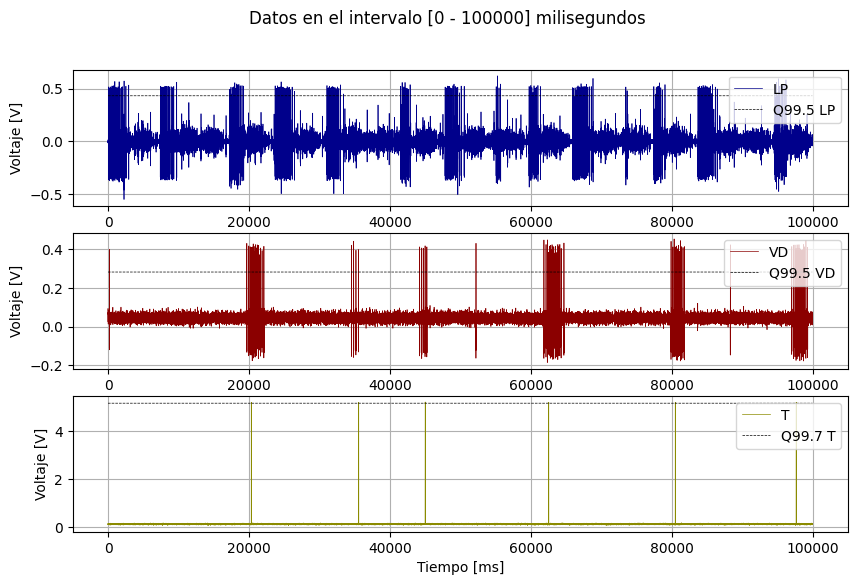

In [232]:
perc = get_percentiles(trozoG, q=[0.995, 0.995, 0.997])
print("Percentiles:\n {}".format(perc))
plot_data(trozoG,
          lines = perc,
          lines_titles = ["Q99.5 LP", "Q99.5 VD", "Q99.7 T"],
          x = [0,100000])

El siguiente paso es normalizar las señales en el sentido de considerar todas las señales que hemos considerado que son spikes con altura de 1 mientras que todas las señales que no sean spikes serán 0. Así nuestra señal inicial estará compuesta por una secuencia de unos y ceros.

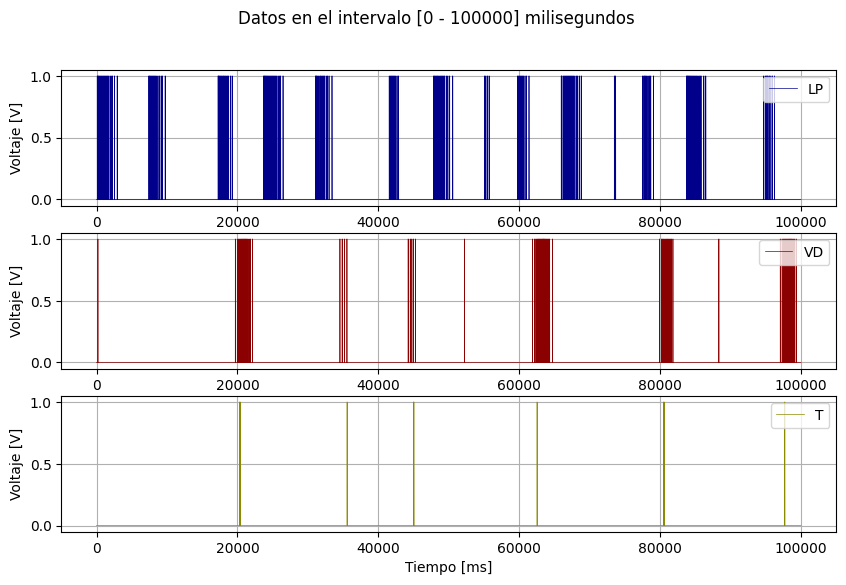

In [233]:
trozoG_umbral = (trozoG > perc).astype(int)
plot_data(trozoG_umbral, x =[0,100000]) 

In [234]:
trozoG_umbral.iloc[20320:20340,:]

,LP,VD,T
20320,0,0,0
20321,0,0,0
20322,0,0,0
20323,0,0,0
20324,0,0,0
20325,0,0,0
20326,0,0,0
20327,0,0,0
20328,0,1,0
20329,0,1,0


El problema de esta codificación es que algunos spikes duran más de un milisegundo y por tanto hay señales que se componen por varios unos seguidos que deben ser reducidas a solamente un uno.

Para ello, vamos a considerar que el spike ocurre en el primer 1 de nuestros subconjuntos de 1 seguidos. Así, si nuestra señal detecta que un 1 es seguido por otro 1, el segundo se convierte en un 0 y así sucesivamente.

In [235]:
def _process_consecutive_ones_vector(vec, i):
    start = i
    while i < len(vec) and vec[i] == 1:
        i += 1
    end = i
    vec[start:end] = 0
    vec[start] = 1
    return i+1  # Devuelve la posicion del siguiente valor despues del 0 que sigue al spike

def minimize_ones_in_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
        Ejecución in place
    """
    for col in range(len(df.columns)):
        vec = np.array(df.iloc[:, col])
        i = 0
        while i < len(vec):
            if vec[i] == 1:
                i = _process_consecutive_ones_vector(vec, i)
            else:
                i += 1
        df.iloc[:, col] = vec
    return df

Se puede observar como el conjunto de unos anteriores ha pasado a ser un único valor de 1, lo que significa que ahora nuestras spikes han pasado a ocurrir en un solo milisegundo.

Así, ya tenemos los datos preparados para poder encontrar el tiempo mínimo que ocurre entre spike y spike.

In [236]:
trozoG_minimizado = minimize_ones_in_dataframe(trozoG_umbral.copy())
trozoG_minimizado.iloc[20320:20340,:]

,LP,VD,T
20320,0,0,0
20321,0,0,0
20322,0,0,0
20323,0,0,0
20324,0,0,0
20325,0,0,0
20326,0,0,0
20327,0,0,0
20328,0,1,0
20329,0,0,0


## 3. BÚSQUEDA DEL TAMAÑO DE VENTANA ÓPTIMO

Necesitamos reducir el tamaño de nuestra muestra de datos para estudiarla y analizarla más rápidamente. Actualmente tenemos un vector compuesto por ceros y unos donde los unos representan la ocurrencia de un evento de spike.

Sin embargo, estos vectores están compuestos en su mayoría por ceros por lo que tenemos mucha información que no nos aporta nada. Es por ello que debemos eliminar los ceros sobrantes, es decir, reducir el tamaño de la ventana temporal. Así, ahora la aparición de un 0 representará que han ocurrido muchos más milisegundos que antes puesto que ahora el 0 representará un tamaño de ventana mayor, concretamente el valor mínimo de tiempo entre dos spikes de nuestro conjunto de muestras. El siguiente código calcula exactamente eso:

In [237]:
import itertools

def get_zeros_between_spikes(df: pd.DataFrame) -> list[list]:
    arrays_zeros = [ [] for i in range(len(df.columns)) ]
    for idx,col in enumerate(df.columns):
        dtype = [('spike',int),('length',int)]
        vector = np.array([ (x , len(list(y)))
                    for x, y in itertools.groupby(df[col].values)],
                    dtype=dtype)
        sorted_vector = np.sort(vector,order=['spike','length'])
        arrays_zeros[idx] = np.array([v[1] for v in sorted_vector if v[0] == 0])
    return arrays_zeros

spaces_between_ones_sorted_G = get_zeros_between_spikes(trozoG_minimizado)
spaces_between_ones_sorted_G

[array([   24,    25,    44, ..., 12603, 12718, 14119]),
 array([   62,    63,    64, ..., 20802, 21351, 21408]),
 array([    1,     1,     1, ..., 44643, 72081, 76316])]

Hemos obtenido el resultado de las diferencias entre dos spikes, obteniendo un valor mínimo de 24 ms y un valor máximo de 14 119 ms para la neurona LP. Sin embargo, debemos estudiar si ese valor mínimo de 24 ms es un outlier o se trata de un valor bastante común. A partir de ahora vamos a descartar el estudio de T puesto que no nos aporta valor para el cálculo de la información mutua. Por todo ello representamos en un histograma la frecuencia de los tiempos entre spike y spike:

In [238]:
def plot_histograms_zoom(trozo: list, yscale: str = 'log', xlims: list[int] = [750,200], xlabel: str = ""):
    import seaborn as sns

    xlims_ = sorted(xlims, reverse=True)

    trozo_np = np.array(trozo, dtype=np.float32)

    _ , bins = np.histogram(trozo_np, bins='auto')

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    sns.histplot(trozo_np, bins=bins, ax=ax1)
    sns.histplot(trozo_np, bins=bins, ax=ax2)
    sns.histplot(trozo_np, bins=bins, ax=ax3)

    for ax, size in zip([ax1, ax2, ax3], [max(trozo)] + xlims):
        ax.set_ylabel("")
        ax.set_xlabel(f"Rango {xlabel} (0-{size}) ms")

    ax2.set_xlim(0, xlims_[0])
    ax3.set_xlim(0, xlims_[1])

    for ax in [ax1, ax2, ax3]:
        ax.set_yscale(yscale)

    plt.tight_layout()
    fig.suptitle(f'Histogramas de frecuencias del tiempo entre spike y spike para la neurona {xlabel}')
    plt.ylabel('Frecuencia')
    plt.tight_layout()
    plt.show()

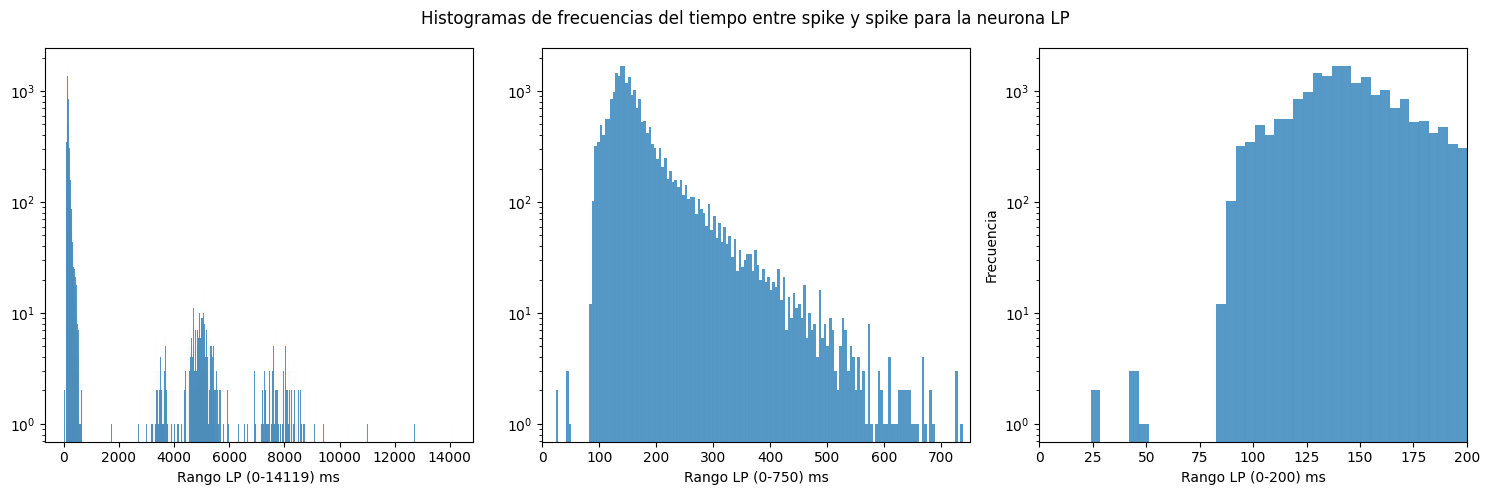

In [239]:
plot_histograms_zoom(spaces_between_ones_sorted_G[0], xlabel="LP")

Como se puede observar, en el tiempo entre dos spikes consecutivas, tenemos que en la nuerona LP hay solamente 6 valores por debajo de 55 ms meintras que la grandísima mayoría (millones de distancias) se encuentran por encima des estos valores. Es por ello que se van a considerar todas las distancias entre spikes menores que 55 ms como outliers y se va a trabajar únicamente con los datos que no son outliers.

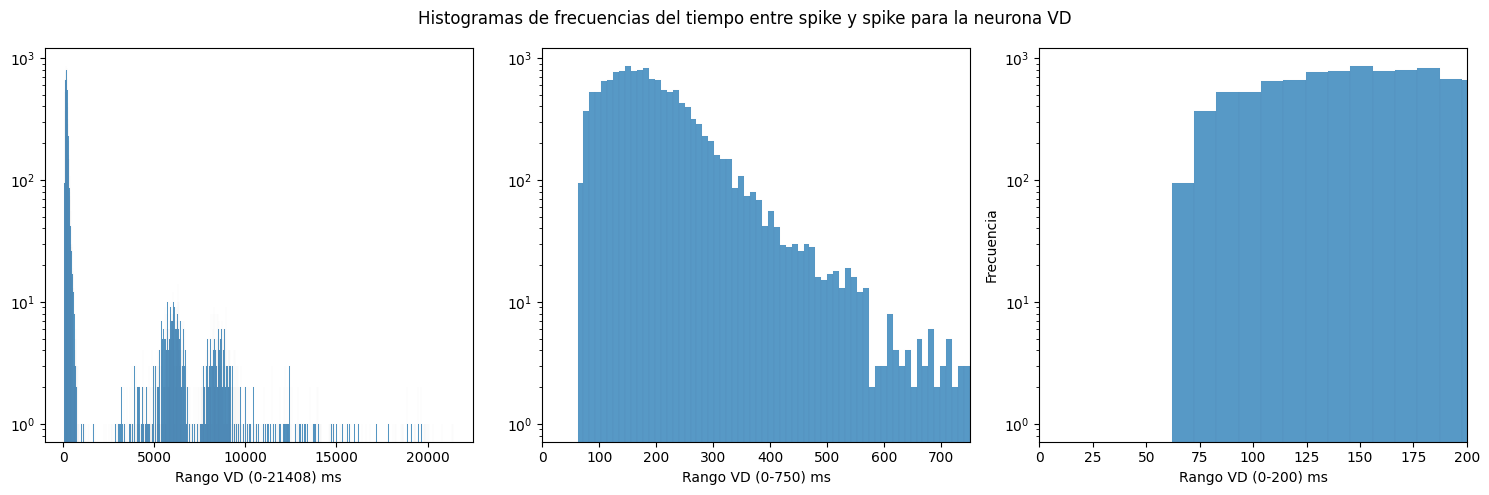

In [240]:
plot_histograms_zoom(spaces_between_ones_sorted_G[1], xlabel="VD")

Para la neurona VD no encontramos valores fuera de la mayoría de sucesos por lo que no vamos a considerar outliers en este caso y por tanto se va a trabajar con el total de los sucesos.

Por tanto, vamos a eliminar los outliers de la neurona LP, descartando los valores de diferencia entre spikes menores a 55 ms:

In [241]:
def remove_outliers(df: pd.DataFrame, threshold_outlier: int = 55) -> pd.DataFrame:
    df_ = df.copy()
    
    for col in df_.columns:
        col_data = df_[col].values
        grouped_data = [(x, len(list(y))) for x, y in itertools.groupby(col_data)]
        
        for i, (value, length) in enumerate(grouped_data):
            if value == 0 and length < threshold_outlier:
                if i > 0:
                    grouped_data[i - 1] = (0, grouped_data[i - 1][1])
                if i < len(grouped_data) - 1:
                    grouped_data[i + 1] = (0, grouped_data[i + 1][1])
        
        df_[col] = np.concatenate([np.repeat(value, length) for value, length in grouped_data])
    
    return df_

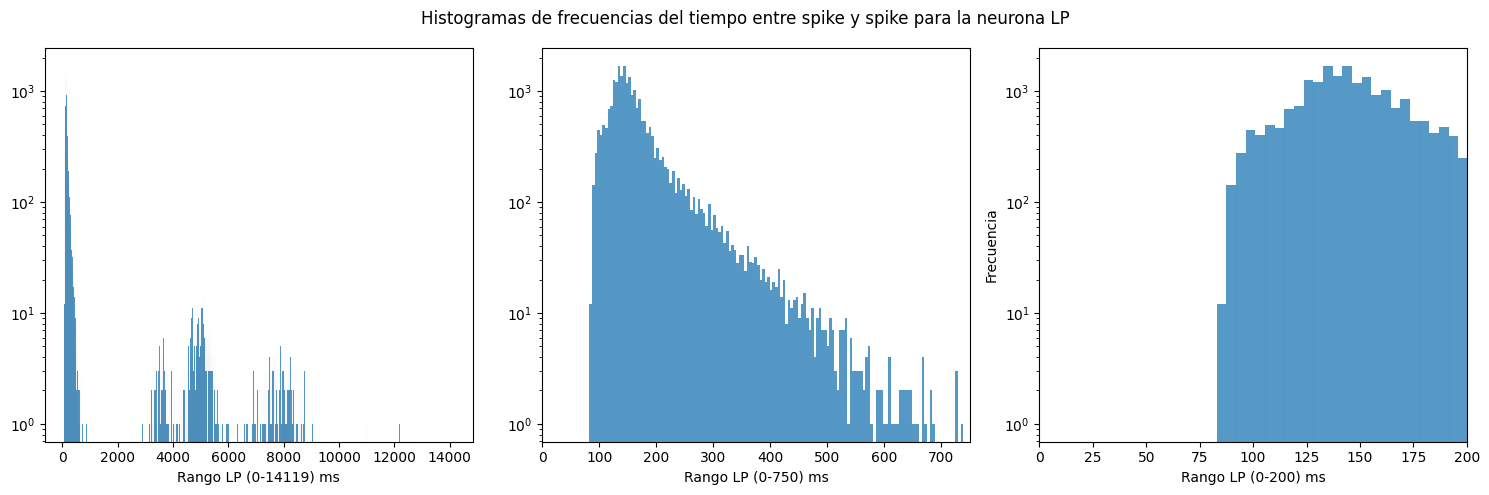

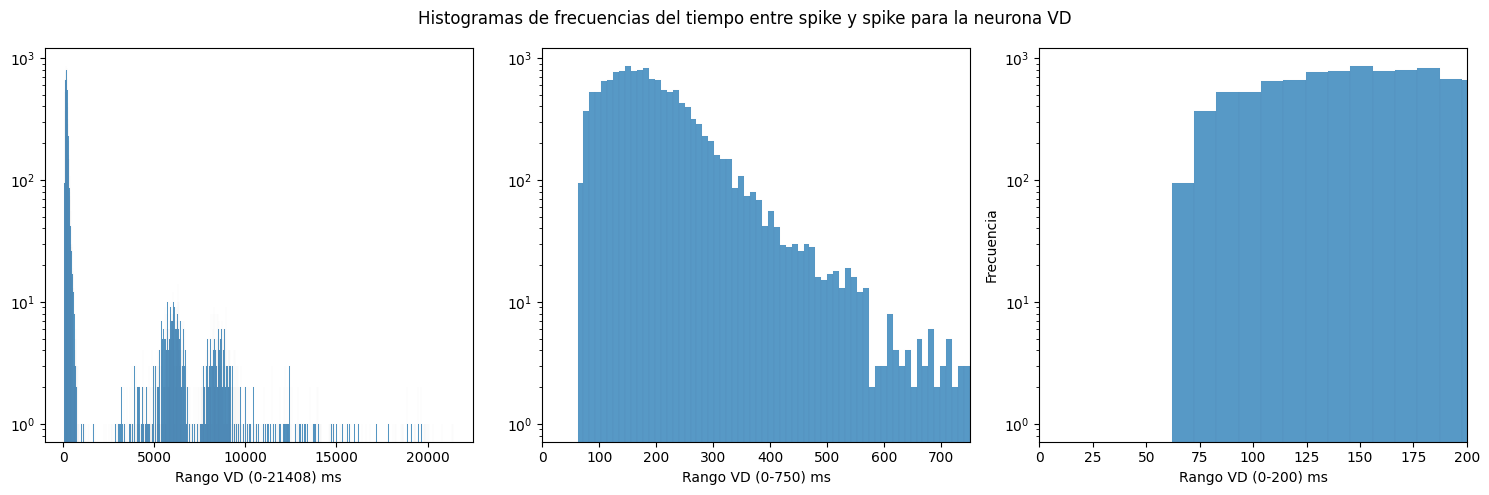

In [242]:
trozoG_no_outliers = remove_outliers(trozoG_minimizado)
spaces_no_outliers_G = get_zeros_between_spikes(trozoG_no_outliers)

for parte, typeCol in zip(spaces_no_outliers_G[:2], ["LP", "VD"]):
    plot_histograms_zoom(trozo=parte, xlabel=typeCol)

En esta ocasión se han descartado los outliers de la neurona LP como se ha podido observar por lo que ya tenemos nuestras distancias sin outliers que puedan afectar a nuestra elección de la ventana óptima.

Una vez que hemos eliminiado los outliers de nuestras muestras, ya podemos considerar el valor mínimo de ventana obtenido como nuestro valor óptimo de ventana. Así, vamos discretizar nuestro tiempo en función de los valores de ventana mínimos.

In [243]:
def get_min_spaces(spaces: list[list]) -> int:

    return min(int(space_min[0]) for space_min in spaces)

windows_size_G = get_min_spaces(spaces_no_outliers_G)

In [244]:
def reduce_with_window(df, window_size):
    index = np.arange(0, len(df) + 1, window_size)
    
    result = np.zeros((len(index) - 1, df.shape[1]), dtype=int)
    
    for i, col in enumerate(df.columns):
        data = df[col].values
        for j, (i1, i2) in enumerate(zip(index[:-1], index[1:])):
            if np.any(data[i1:i2] == 1):
                result[j, i] = 1
    
    return pd.DataFrame(result, columns=df.columns)

In [245]:
def _create_discretization(trozo: pd.DataFrame, q: list[int]) -> pd.DataFrame:
    perc = get_percentiles(trozo, q=q)
    trozo_threshold = (trozo > perc).astype(int)
    trozo_minimized = minimize_ones_in_dataframe(trozo_threshold.copy())
    return remove_outliers(trozo_minimized)

def _create_reduction(trozo_no_outliners: pd.DataFrame, windows_size: int = None) -> pd.DataFrame:
    if not windows_size:
        spaces = get_zeros_between_spikes(trozo_no_outliners)

        windows_size = get_min_spaces(spaces)

        print(f"Tamaño de ventana óptimo: {windows_size}")
    return reduce_with_window(trozo_no_outliners, windows_size)

def compute_trozo(trozo: pd.DataFrame, q: list[int], windows_size: int = None) -> pd.DataFrame:
    discretized_trozo = _create_discretization(trozo, q)
    return _create_reduction(discretized_trozo, windows_size)

trozoG_reducido = compute_trozo(trozoG, [0.995, 0.995, 0.9975])
trozoG_reducido_filtered = trozoG_reducido[['LP','VD']]

Tamaño de ventana óptimo: 62


Una vez hemos reducido nuestros datos, ahora contenemos un conjunto de ceros y unos donde los unos (las spikes) están separadas por, como poco, un cero que representa 62 ms (en el caso de los datos de GABA). Ahora podemos estudiar con cuánta cantidad de los datos iniciales nos hemos quedado del conjunto original, que era nuestro objetivo para más adelante facilitar los cálculos de la entropía y de la información mutua.

In [246]:
def get_reduced_percentage(trozo_reduced: pd.DataFrame, trozo: pd.DataFrame) -> float:
    return print(f'Porcentaje de datos utilizados en relación con los originales: {len(trozo_reduced.iloc[:,0])/len(trozo.iloc[:,0])*100} %')

get_reduced_percentage(trozoG_reducido, trozoG)

Porcentaje de datos utilizados en relación con los originales: 1.61290283203125 %


Nos hemos quedado con algo más que el 1% de nuestro conjunto de datos iniciales lo que hará que los cálculos posteriores sean mucho más ligeros.

En la siguiente parte vamos a repetir este proceso para los otros conjuntos de datos, el trozo C (control) y el trozo R (reposo). Recordemos que estos trozos solo tienen valores del voltaje de las neuronas LP y VD.

### 3.1. Búsqueda del tamaño de venta óptimo para los datos de control

Repetimos el procedimiento que hemos realizado con los datos de inyección de GABA pero con los datos de control:

In [247]:
trozoC = pd.read_csv("Datos/TrozoC.txt", names = ["LP", "VD"],
                     usecols = [0, 1],
                     delimiter = "\t", skiprows = range(3), 
                     index_col = False, decimal = ",")

trozoC.head(10)

,LP,VD
0,0.004883,0.015259
1,0.001526,0.024109
2,-0.010681,0.031128
3,-0.022278,0.041809
4,-0.028076,0.045471
5,-0.034180,0.047913
6,-0.045166,0.058899
7,-0.048523,0.057068
8,-0.049438,0.062256
9,-0.048828,0.064697


Representamos los histogramas de frecuencias de voltaje para visualizar donde se encuentra la población de spikes:

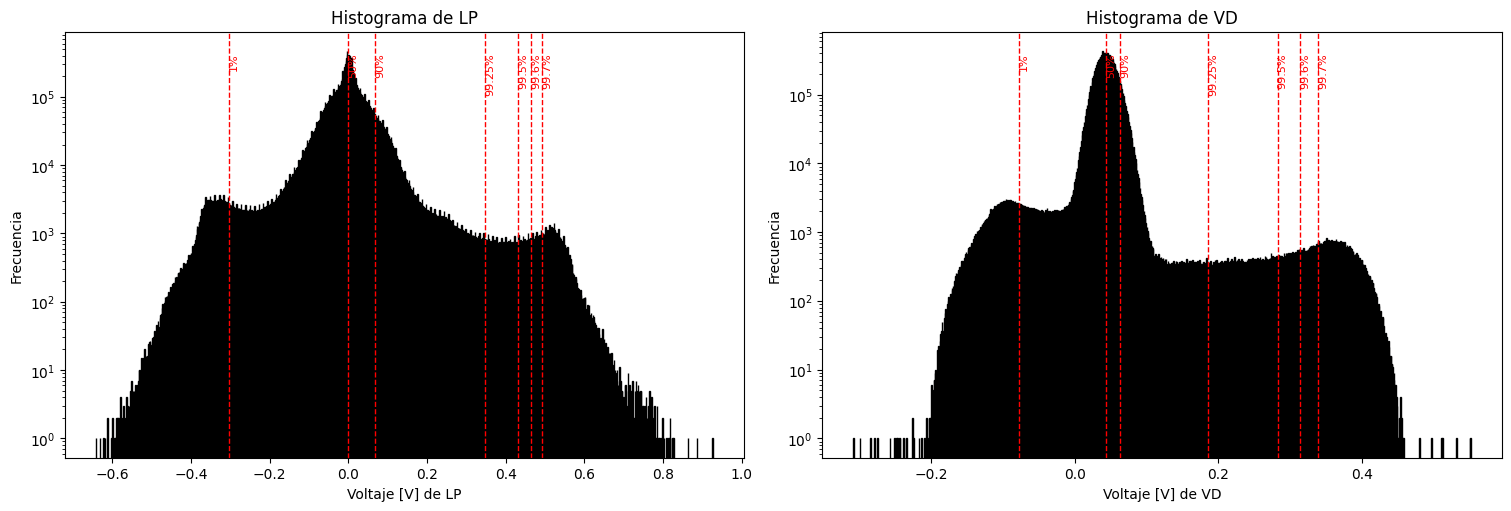

In [248]:
percentiles = [1, 50, 90, 99.25, 99.5, 99.6, 99.7]
plot_histograms_with_percentiles(trozoG, percentiles=percentiles)

Como se puede observar a partir de los histogramas, la población de máximos de los spikes para el control se encuentra en el percentil aproximadamente 99.5% tanto para la neurona LP como para la neurona VD.

Vamos a juntar todas las funciones realizadas previamente en una sola función para poder aplicarla a los datos de control. Esto nos devolverá el tamaño de ventana máximo para no perder spikes y que caigan varias en una sola ventana temporal además de que nos devolverá el porcentaje de datos (el tamaño relativo) con respecto al tamaño de los datos originales:

In [249]:
# Computación previa antes de crear la función compute_trozo
perc = get_percentiles(trozoC, q=[0.995, 0.995])
trozoC_umbral = (trozoC > perc).astype(int)
trozoC_minimizado = minimize_ones_in_dataframe(trozoC_umbral.copy())
trozoC_no_outliers = remove_outliers(trozoC_minimizado)

In [250]:
trozoC_reducido = compute_trozo(trozoC, [0.995, 0.995])

Tamaño de ventana óptimo: 60


In [251]:
get_reduced_percentage(trozoC_reducido, trozoC)

Porcentaje de datos utilizados en relación con los originales: 1.6666666666666667 %


### 3.2. Búsqueda del tamaño de venta óptimo para los datos de reposo

Repetimos el procedimiento que hemos realizado con los datos de inyección de GABA pero con los datos de reposo:

In [252]:
trozoR = pd.read_csv("Datos/TrozoR.txt", names = ["LP", "VD"],
                     usecols = [0, 1],
                     delimiter = "\t", skiprows = range(3), 
                     index_col = False, decimal = ",")

trozoR.head(10)

,LP,VD
0,-0.008240,0.084534
1,-0.009460,0.070190
2,-0.014038,0.049133
3,-0.021973,0.035400
4,-0.035095,0.022888
5,-0.042114,0.008850
6,-0.047607,0.009460
7,-0.057678,0.012207
8,-0.061646,0.018311
9,-0.086060,0.021973


Representamos los histogramas de frecuencias de voltaje para visualizar donde se encuentra la población de spikes:

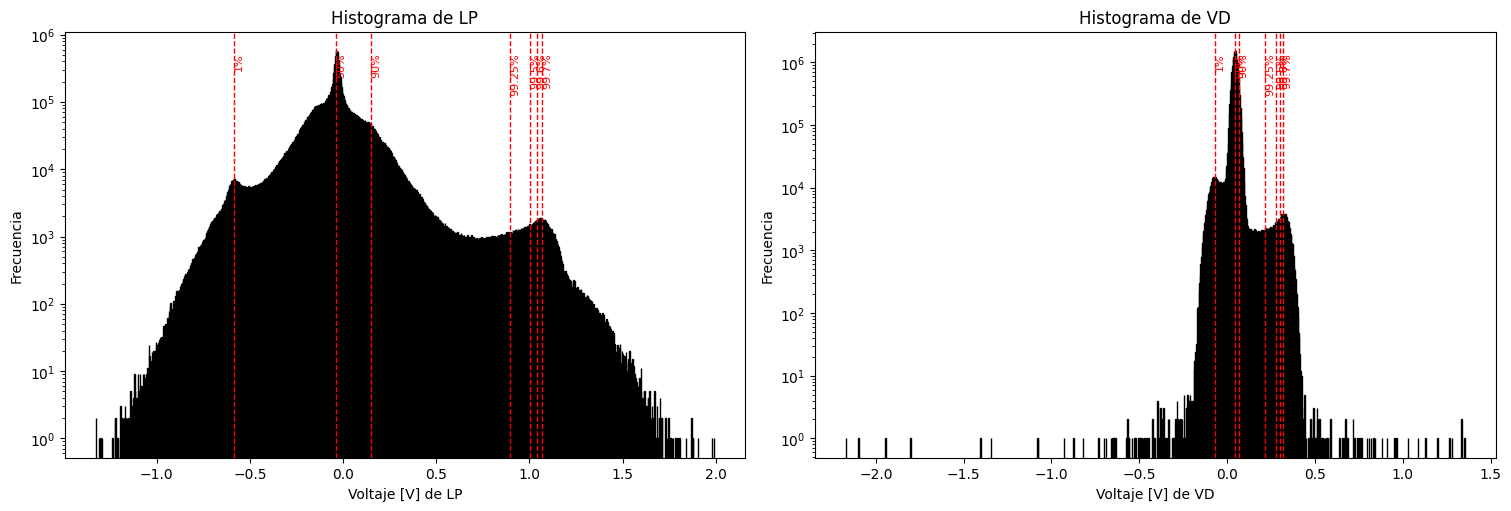

In [253]:
plot_histograms_with_percentiles(trozoR, percentiles=percentiles)

Como se puede observar a partir de los histogramas, la población de los máximos de los spikes tanto en LP como en VD se encuentra aproximadamente en el percentil 99.5% para el caso de reposo.

Al igual que antes, vamos a juntar todas las funciones realizadas previamente en una sola función para poder aplicarla a los datos de reposo. Esto nos devolverá el tamaño de ventana máximo para no perder spikes y que caigan varias en una sola ventana temporal además de que nos devolverá el porcentaje de datos (el tamaño relativo) con respecto al tamaño de los datos originales:

In [254]:
# Computación previa antes de crear la función compute_trozo
perc = get_percentiles(trozoR, q=[0.995, 0.995])
trozoR_umbral = (trozoR > perc).astype(int)
trozoR_minimizado = minimize_ones_in_dataframe(trozoR_umbral.copy())
trozoR_no_outliers = remove_outliers(trozoR_minimizado)

In [255]:
trozoR_reducido = compute_trozo(trozoR, [0.995, 0.995])

Tamaño de ventana óptimo: 60


In [256]:
get_reduced_percentage(trozoR_reducido, trozoR)

Porcentaje de datos utilizados en relación con los originales: 1.66666259765625 %


## 4. ENTROPÍA, INFORMACIÓN MUTUA Y TRANSFERENCIA DE INFORMACIÓN

### 4.1. Información mutua y transferencia de información para el tamaño de ventana óptimo

Todo este preprocesado lo hemos realizado para poder estudiar la información contenida en los trenes de spikes obtenidos de la neurona LP y VD. Es por esto que ya no nos interesará el análisis de los datos T de la inyección de GABA. Ahora tenemos unas representaciones de los trenes de spikes que mantienen toda la información de las spikes, siendo muy reducidos con respecto al tamaño original.

El análisis de la información contenida en los spikes y de la información entre las dos neuronas del estudio resulta ser muy interesante. Se pide calcular la transferencia de entropía (información) de la neurona VD a la neurona LP y viceversa. 

A partir de las fórmulas estudiadas en las clases de teoría podemos determinar fácilmente las distintas variables necesarias para encontrar la información mutua, la entropía y la transferencia de información.

Sabemos que la información mutua viene dada por la expresión:

$$
MI(X,Y) = S(X) + S(Y) - S(X,Y)
$$

donde $S(X)$ es la entropía de la variable aleatoria $X$, $S(Y)$ es la entropía de la variable aleatoria $Y$ y $S(X,Y)$ es la entropía conjuntas de estas dos variables aleatorias.

La entropía de un conjunto de ceros y unos se puede describir fácilmente mediante la fórmula vista en teoría:

$$
S(X) = -\sum_i p(x_i) \cdot log_2 p(x_i)
$$

Así se puede entender a la entropía como el promedio de la información de todos los spikes.

Estas variables, aplicadas a nuestro problema, describen la información entre dos neuronas y el promedio de información de los trenes de spikes de cada neurona individual. Sin embargo, también resulta interesante estudiar la información transferida entre una nuerona y otra y viceversa. Esta variable, la tranferencia de información, entre la variable aleatoria $X$ e $Y$ se define como:

$$
E_{XY} = \frac{MI_{X,Y}}{S(Y)}
$$

mientras que la transferencia de información entre la variable aleatoria $Y$ y $X$ es:

$$
E_{YX} = \frac{MI_{X,Y}}{S(X)}
$$


Todo esto depende, sin embargo, del tamaño de palabra que consideremos a la hora de tratar nuestros trenes de spikes. Esto es, en cuantos bits dividimos nuestra información. Mostraremos un ejemplo que divida nuestro conjunto de datos en palabras de tamaño 3:

$$
X = (0 1 0 0 1 0 1 0 1 0 0 1 0 0 0 1 0 1) \Longrightarrow \hat{X} = ( (0 1 0), (1 0 0), (0 0 1), (0 1 0), (1 0 1), ...)
$$

De esta forma, se deben tomar subconjuntos de datos de 1 a 8 bits, es decir, tamaños de palabras de 1 a 8. Así, considerando cada palabra como un evento diferente, se puede calcular la probabilidad de ocurrencia de cada evento (contando el númeoro total de cada evento y diviendo por el total de eventos). Con esta probabilidad, podremos calcular la entropía de cada neurona, la entropía conjunta, y con ello la transferencia de información y la información mutua. Por tanto, en función de cómo tratemos nuestros datos se obtendrán diferentes valores para las variables mencionadas.

Finalmente se va a estudiar la información mutua "normalizada". Esta normalización se hace en función del tamño de ventana y del tamaño de palabra utilizada. Esto es interesante puesto que nos desvela cómo afecta el uso de tamaños de palabras y tamaños de ventanas a la información mutua. De esta forma, definimos la información mutua normalizada como:

$$
\hat{MI}(X,Y) = \frac{MI(X,Y)}{n_{word} \cdot n_{window}}
$$

donde $n_{word}$ es el tamaño de palabra (o número de bits en cada evento) y $ n_{window}$ es el tamño de ventana.

Todos estos cálculos vamos a resumirlos en una clase de `Python` para llamar a las funciones necesarias de forma sencilla.

In [257]:
class MI:
    def __init__(self, X: np.ndarray, Y: np.ndarray, word_sizes: np.ndarray) -> None:
        self.X = X
        self.Y = Y
        self.word_sizes = word_sizes

        self.entropy_X, self.entropy_Y, self.entropy_XY = None, None, None
        self.it_XY, self.it_YX = None, None

    def compute_MI_IT(self) -> None:
        self.entropy_X, self.entropy_Y, self.entropy_XY = self.calculate_entropy()
        self.mi = self.entropy_X + self.entropy_Y - self.entropy_XY

        self.it_XY = self.mi / self.entropy_X
        self.it_YX = self.mi / self.entropy_Y

    def compute_norm_MI(self, window_size: float) -> np.ndarray:
        return self.mi / (self.word_sizes * window_size)


    def __calculate_entropy(self, X: np.ndarray) -> np.ndarray:
        entropy_values = np.zeros(len(self.word_sizes))

        for index, size in enumerate(self.word_sizes):
            
            sub_matrices = np.array([X[:, col:col + size] for col in range(X.shape[1] - size)])

            _, frequencies = np.unique(sub_matrices, axis=0, return_counts=True)

            probability_dist = frequencies / np.sum(frequencies)

            entropy_values[index] = -np.sum(probability_dist * np.log2(probability_dist))

        return entropy_values
    
    def calculate_entropy(self) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
        return (self.__calculate_entropy(self.X),
                self.__calculate_entropy(self.Y),
                self.__calculate_entropy(np.vstack((self.X,self.Y))))
    
    
    def get_data(self) -> pd.DataFrame:
        titles = ["Sx", "Sy", "Sxy", "MI", "E_xy", "E_yx"]
        data = list(zip(self.entropy_X, self.entropy_Y, self.entropy_XY, self.mi, self.it_XY, self.it_YX))
        return pd.DataFrame(data,index = self.word_sizes ,columns = titles)

In [258]:
def get_columns_as_array(df: pd.DataFrame) -> tuple[np.ndarray]:
    return (df.to_numpy()[:,i].T.reshape(1,-1) for i in range(len(df.columns)))

Definimos el tamaño de palabras a usar y obtenemos la información muuta, la entropía y la información mutua normalizada entre la neurona LP (correspondiente a la variable $X$) y la neurona VD (correspondiente a la variable $Y$) para la inyección de GABA:

In [259]:
word_sizes = np.arange(1,9,1)
Xg, Yg = get_columns_as_array(trozoG_reducido_filtered)
G_information = MI(Xg, Yg, word_sizes)

In [260]:
G_information.compute_MI_IT()
G_df = G_information.get_data()

print(G_df)

         Sx        Sy       Sxy        MI      E_xy      E_yx
1  0.464303  0.324170  0.781098  0.007376  0.015886  0.022753
2  0.923020  0.648305  1.541141  0.030184  0.032702  0.046559
3  1.317564  0.950146  2.212848  0.054862  0.041639  0.057741
4  1.625935  1.201948  2.757510  0.070373  0.043281  0.058549
5  1.911217  1.413994  3.244054  0.081156  0.042463  0.057395
6  2.178703  1.602407  3.690710  0.090400  0.041493  0.056415
7  2.433872  1.778953  4.113366  0.099459  0.040865  0.055909
8  2.678138  1.949388  4.518361  0.109165  0.040761  0.055999


Representamos estas variables de interés en función del tamaño de la palabra utilizado:

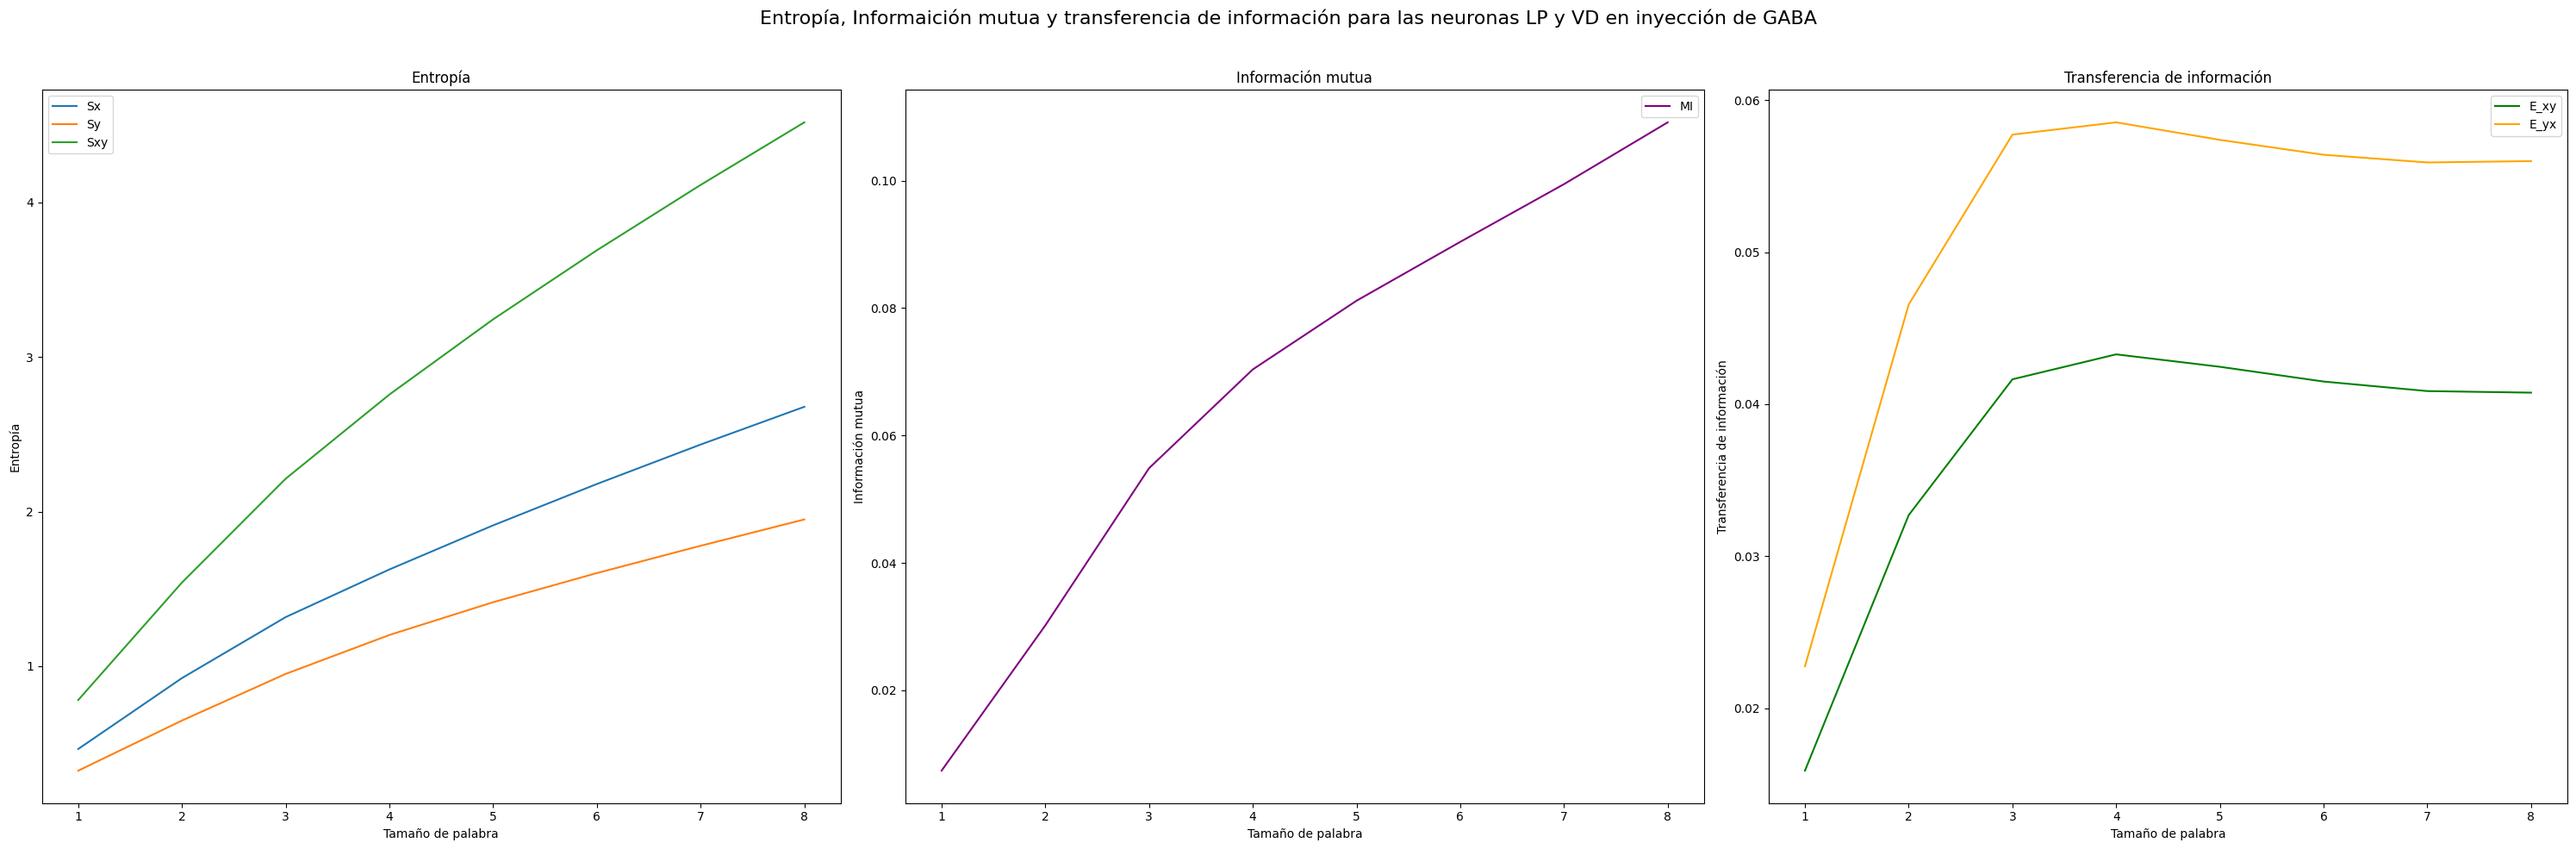

In [261]:
fig, axs = plt.subplots(1, 3, figsize=(30, 10))

# Entorpy plot
axs[0].plot(G_df.index, G_df.iloc[:, 0], label=G_df.columns[0])
axs[0].plot(G_df.index, G_df.iloc[:, 1], label=G_df.columns[1])
axs[0].plot(G_df.index, G_df.iloc[:, 2], label=G_df.columns[2])

axs[0].set_title('Entropía')
axs[0].set_xlabel('Tamaño de palabra')
axs[0].set_ylabel('Entropía')
axs[0].legend()

# Mutual Information plot
axs[1].plot(G_df.index, G_df.iloc[:, 3], label=G_df.columns[3], color='purple')

axs[1].set_title('Información mutua')
axs[1].set_xlabel('Tamaño de palabra')
axs[1].set_ylabel('Información mutua') 
axs[1].legend()

# Information Transfer plot
axs[2].plot(G_df.index, G_df.iloc[:, 4], label=G_df.columns[4], color='green')
axs[2].plot(G_df.index, G_df.iloc[:, 5], label=G_df.columns[5], color='orange')

axs[2].set_title('Transferencia de información') 
axs[2].set_xlabel('Tamaño de palabra')
axs[2].set_ylabel('Transferencia de información')
axs[2].legend()

fig.suptitle('Entropía, Informaición mutua y transferencia de información para las neuronas LP y VD en inyección de GABA', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()

## ANÁLISIS GRÁFICAS

         Sx        Sy       Sxy        MI      E_xy      E_yx
1  0.446257  0.350349  0.788320  0.008287  0.018569  0.023652
2  0.886423  0.700551  1.551872  0.035102  0.039599  0.050106
3  1.273852  1.012721  2.223168  0.063405  0.049774  0.062608
4  1.568093  1.249333  2.739134  0.078292  0.049928  0.062667
5  1.839481  1.453815  3.204569  0.088728  0.048235  0.061031
6  2.094129  1.639872  3.636257  0.097744  0.046675  0.059604
7  2.336824  1.817008  4.047261  0.106570  0.045605  0.058652
8  2.568776  1.989780  4.442953  0.115603  0.045003  0.058099


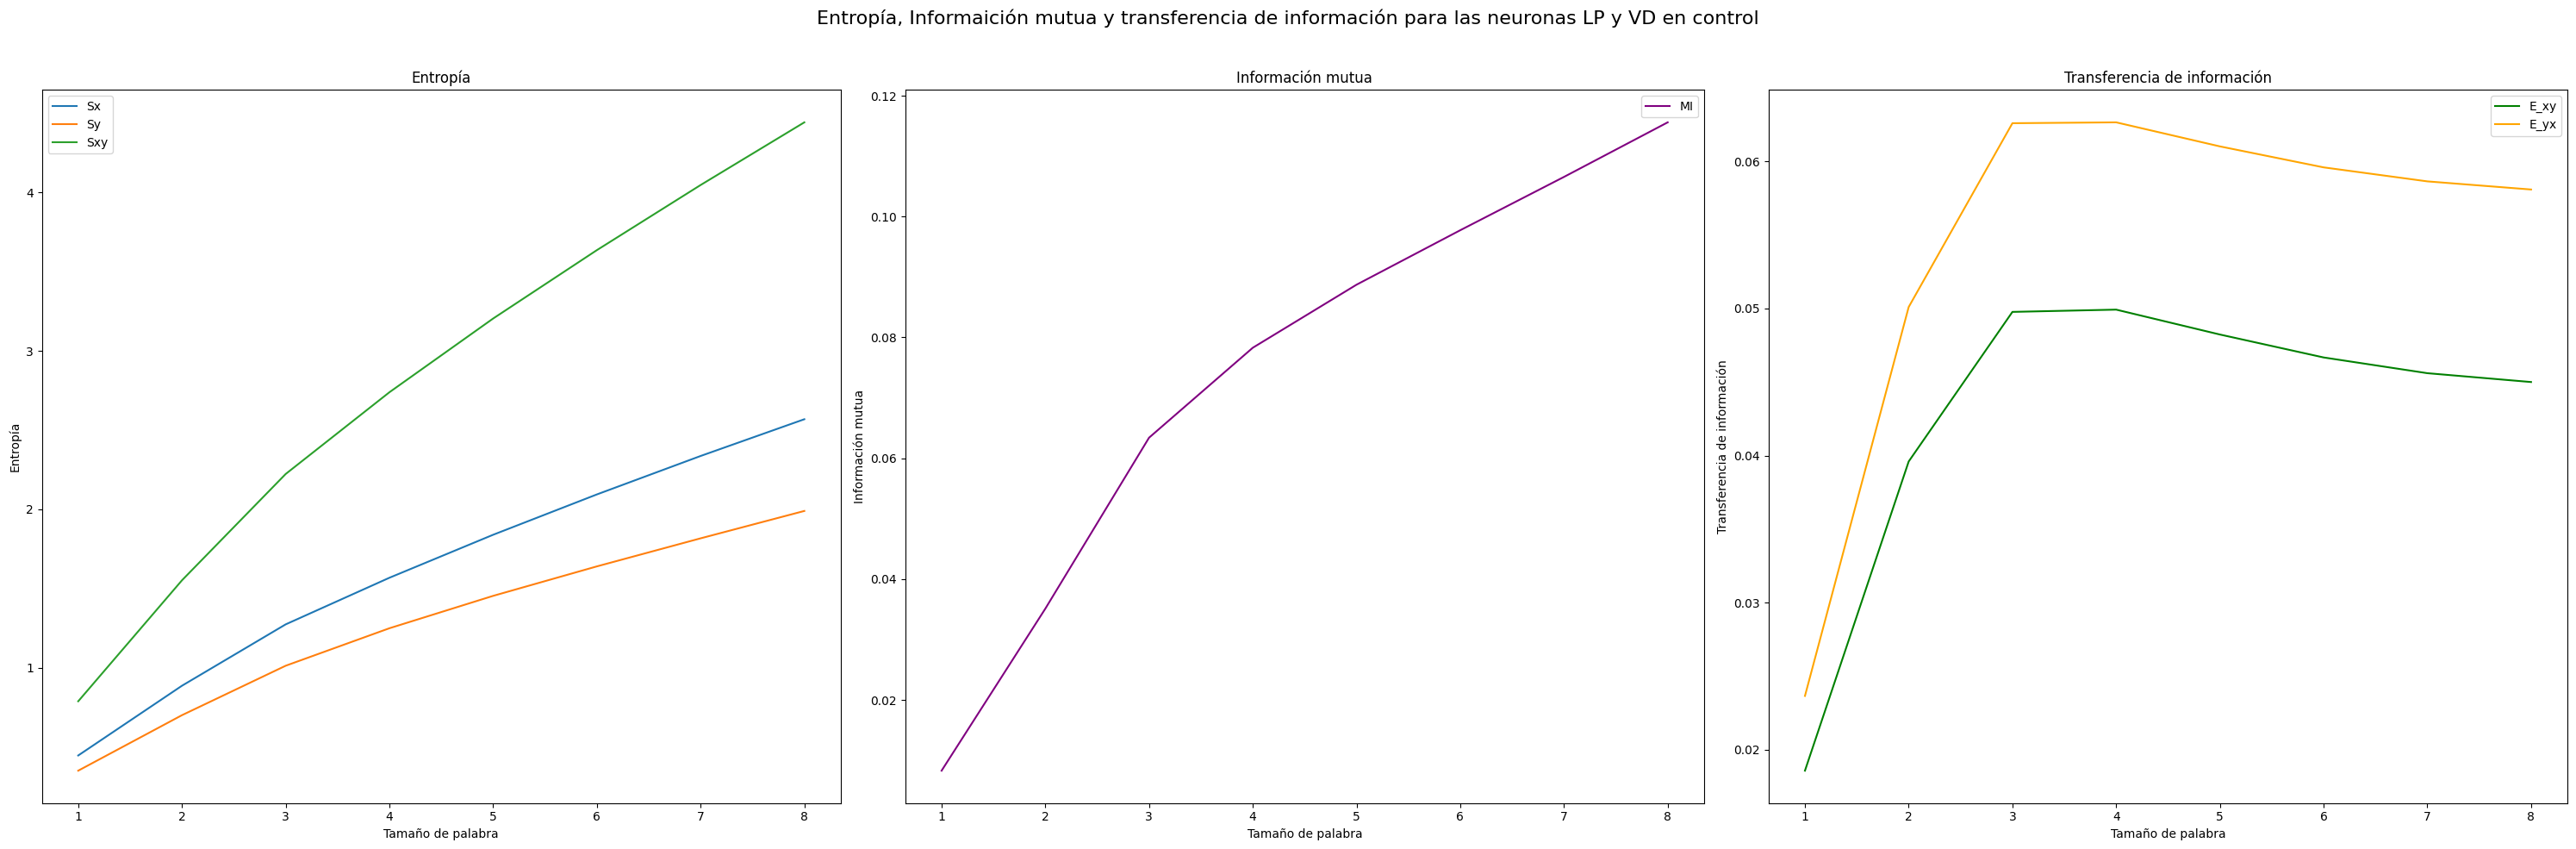

In [262]:
word_sizes = np.arange(1,9,1)
Xc, Yc = get_columns_as_array(trozoC_reducido)
C_information = MI(Xc, Yc, word_sizes)

C_information.compute_MI_IT()
C_df = C_information.get_data()

print(C_df)

fig, axs = plt.subplots(1, 3, figsize=(30, 10))

# Entorpy plot
axs[0].plot(C_df.index, C_df.iloc[:, 0], label=C_df.columns[0])
axs[0].plot(C_df.index, C_df.iloc[:, 1], label=C_df.columns[1])
axs[0].plot(C_df.index, C_df.iloc[:, 2], label=C_df.columns[2])

axs[0].set_title('Entropía')
axs[0].set_xlabel('Tamaño de palabra')
axs[0].set_ylabel('Entropía')
axs[0].legend()

# Mutual Information plot
axs[1].plot(C_df.index, C_df.iloc[:, 3], label=C_df.columns[3], color='purple')

axs[1].set_title('Información mutua')
axs[1].set_xlabel('Tamaño de palabra')
axs[1].set_ylabel('Información mutua') 
axs[1].legend()

# Information Transfer plot
axs[2].plot(C_df.index, C_df.iloc[:, 4], label=C_df.columns[4], color='green')
axs[2].plot(C_df.index, C_df.iloc[:, 5], label=C_df.columns[5], color='orange')

axs[2].set_title('Transferencia de información') 
axs[2].set_xlabel('Tamaño de palabra')
axs[2].set_ylabel('Transferencia de información')
axs[2].legend()

fig.suptitle('Entropía, Informaición mutua y transferencia de información para las neuronas LP y VD en control', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()

## ANÁLISIS GRÁFICAS

         Sx        Sy       Sxy        MI      E_xy      E_yx
1  0.409477  0.352629  0.754924  0.007181  0.017538  0.020365
2  0.814151  0.705228  1.488919  0.030460  0.037413  0.043192
3  1.174669  1.017645  2.137248  0.055066  0.046878  0.054112
4  1.467712  1.257968  2.656070  0.069610  0.047427  0.055335
5  1.745252  1.465980  3.130442  0.080790  0.046291  0.055110
6  2.006156  1.654619  3.570389  0.090387  0.045055  0.054627
7  2.257446  1.833755  3.991736  0.099465  0.044061  0.054241
8  2.501209  2.008433  4.400866  0.108776  0.043489  0.054160


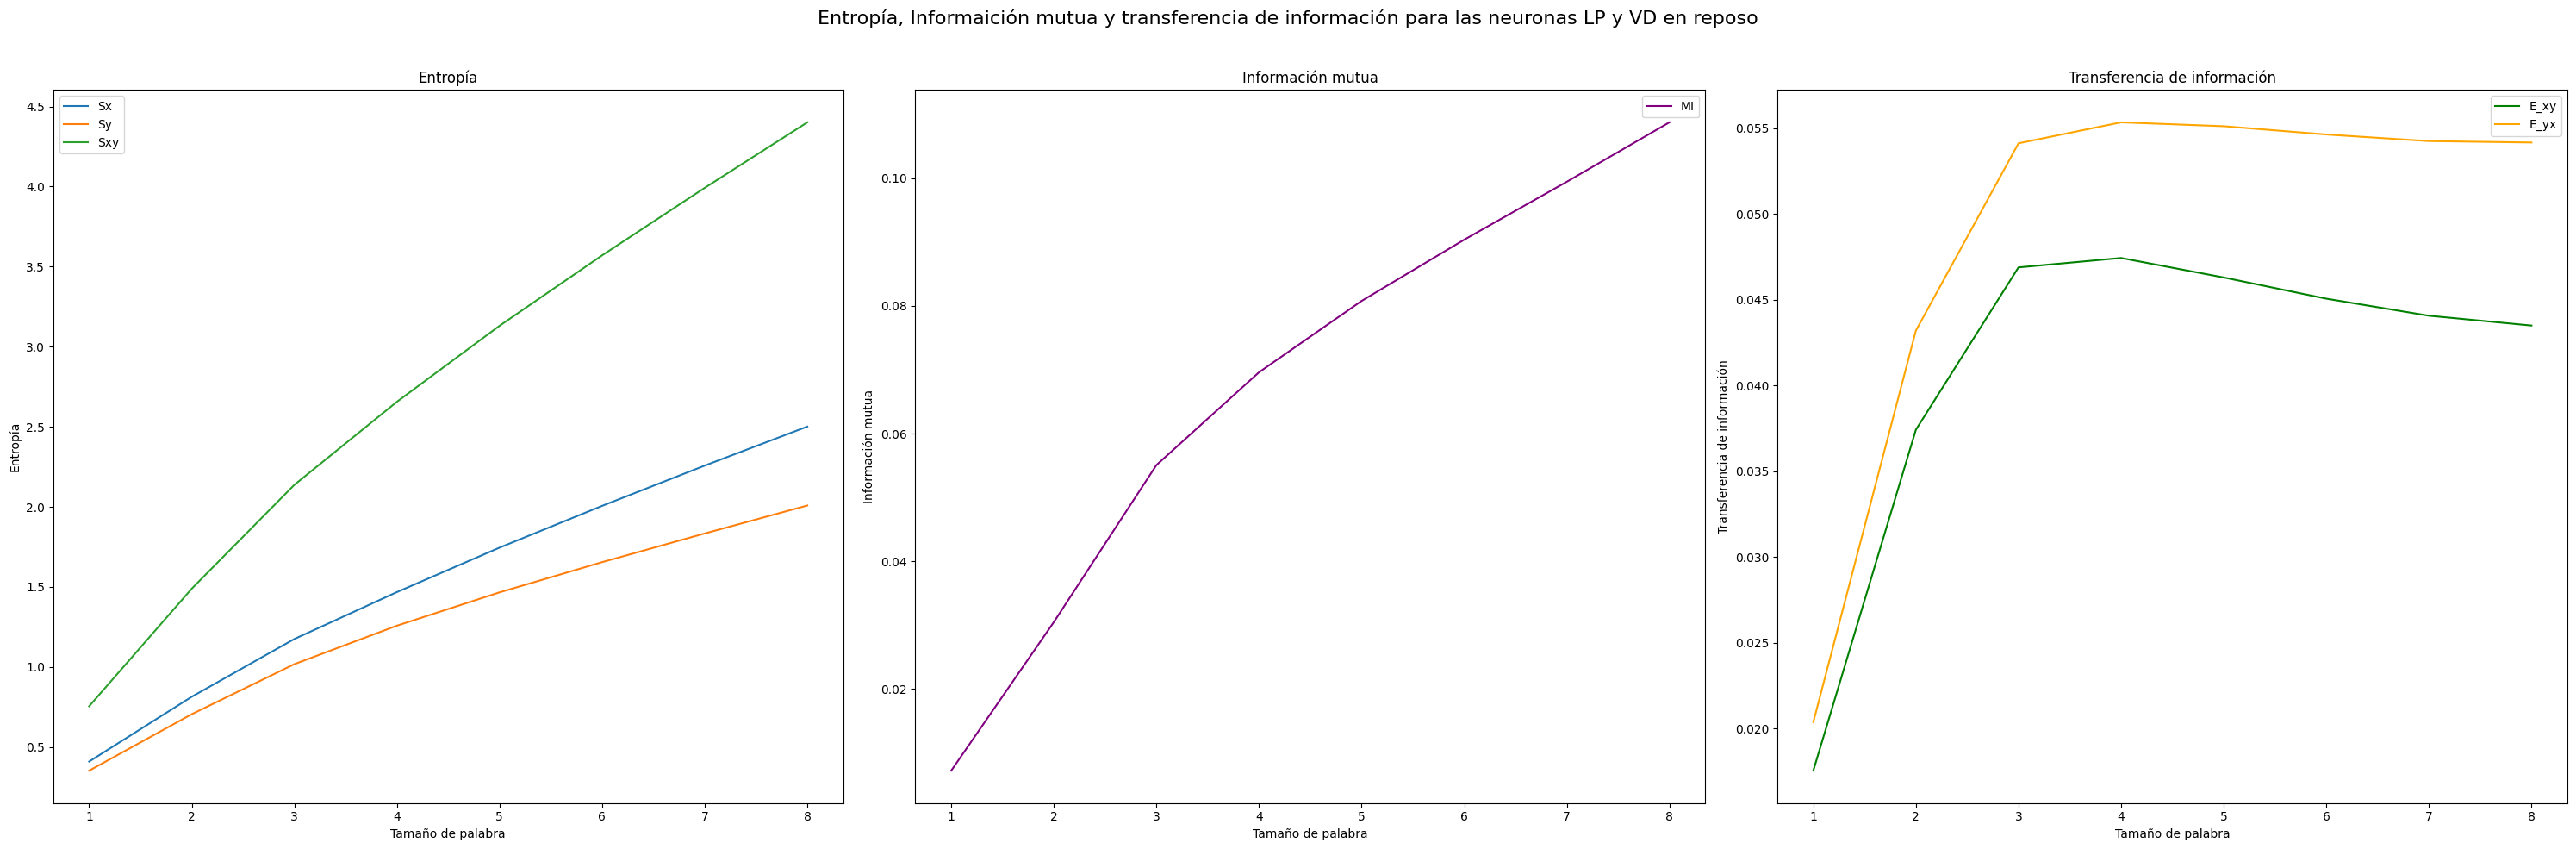

In [263]:
word_sizes = np.arange(1,9,1)
Xr, Yr = get_columns_as_array(trozoR_reducido)
R_information = MI(Xr, Yr, word_sizes)

R_information.compute_MI_IT()
R_df = R_information.get_data()

print(R_df)

fig, axs = plt.subplots(1, 3, figsize=(30, 10))

# Entorpy plot
axs[0].plot(R_df.index, R_df.iloc[:, 0], label=R_df.columns[0])
axs[0].plot(R_df.index, R_df.iloc[:, 1], label=R_df.columns[1])
axs[0].plot(R_df.index, R_df.iloc[:, 2], label=R_df.columns[2])

axs[0].set_title('Entropía')
axs[0].set_xlabel('Tamaño de palabra')
axs[0].set_ylabel('Entropía')
axs[0].legend()

# Mutual Information plot
axs[1].plot(R_df.index, R_df.iloc[:, 3], label=R_df.columns[3], color='purple')

axs[1].set_title('Información mutua')
axs[1].set_xlabel('Tamaño de palabra')
axs[1].set_ylabel('Información mutua') 
axs[1].legend()

# Information Transfer plot
axs[2].plot(R_df.index, R_df.iloc[:, 4], label=R_df.columns[4], color='green')
axs[2].plot(R_df.index, R_df.iloc[:, 5], label=R_df.columns[5], color='orange')

axs[2].set_title('Transferencia de información') 
axs[2].set_xlabel('Tamaño de palabra')
axs[2].set_ylabel('Transferencia de información')
axs[2].legend()

fig.suptitle('Entropía, Informaición mutua y transferencia de información para las neuronas LP y VD en reposo', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()

## ANÁLISIS GRÁFICAS

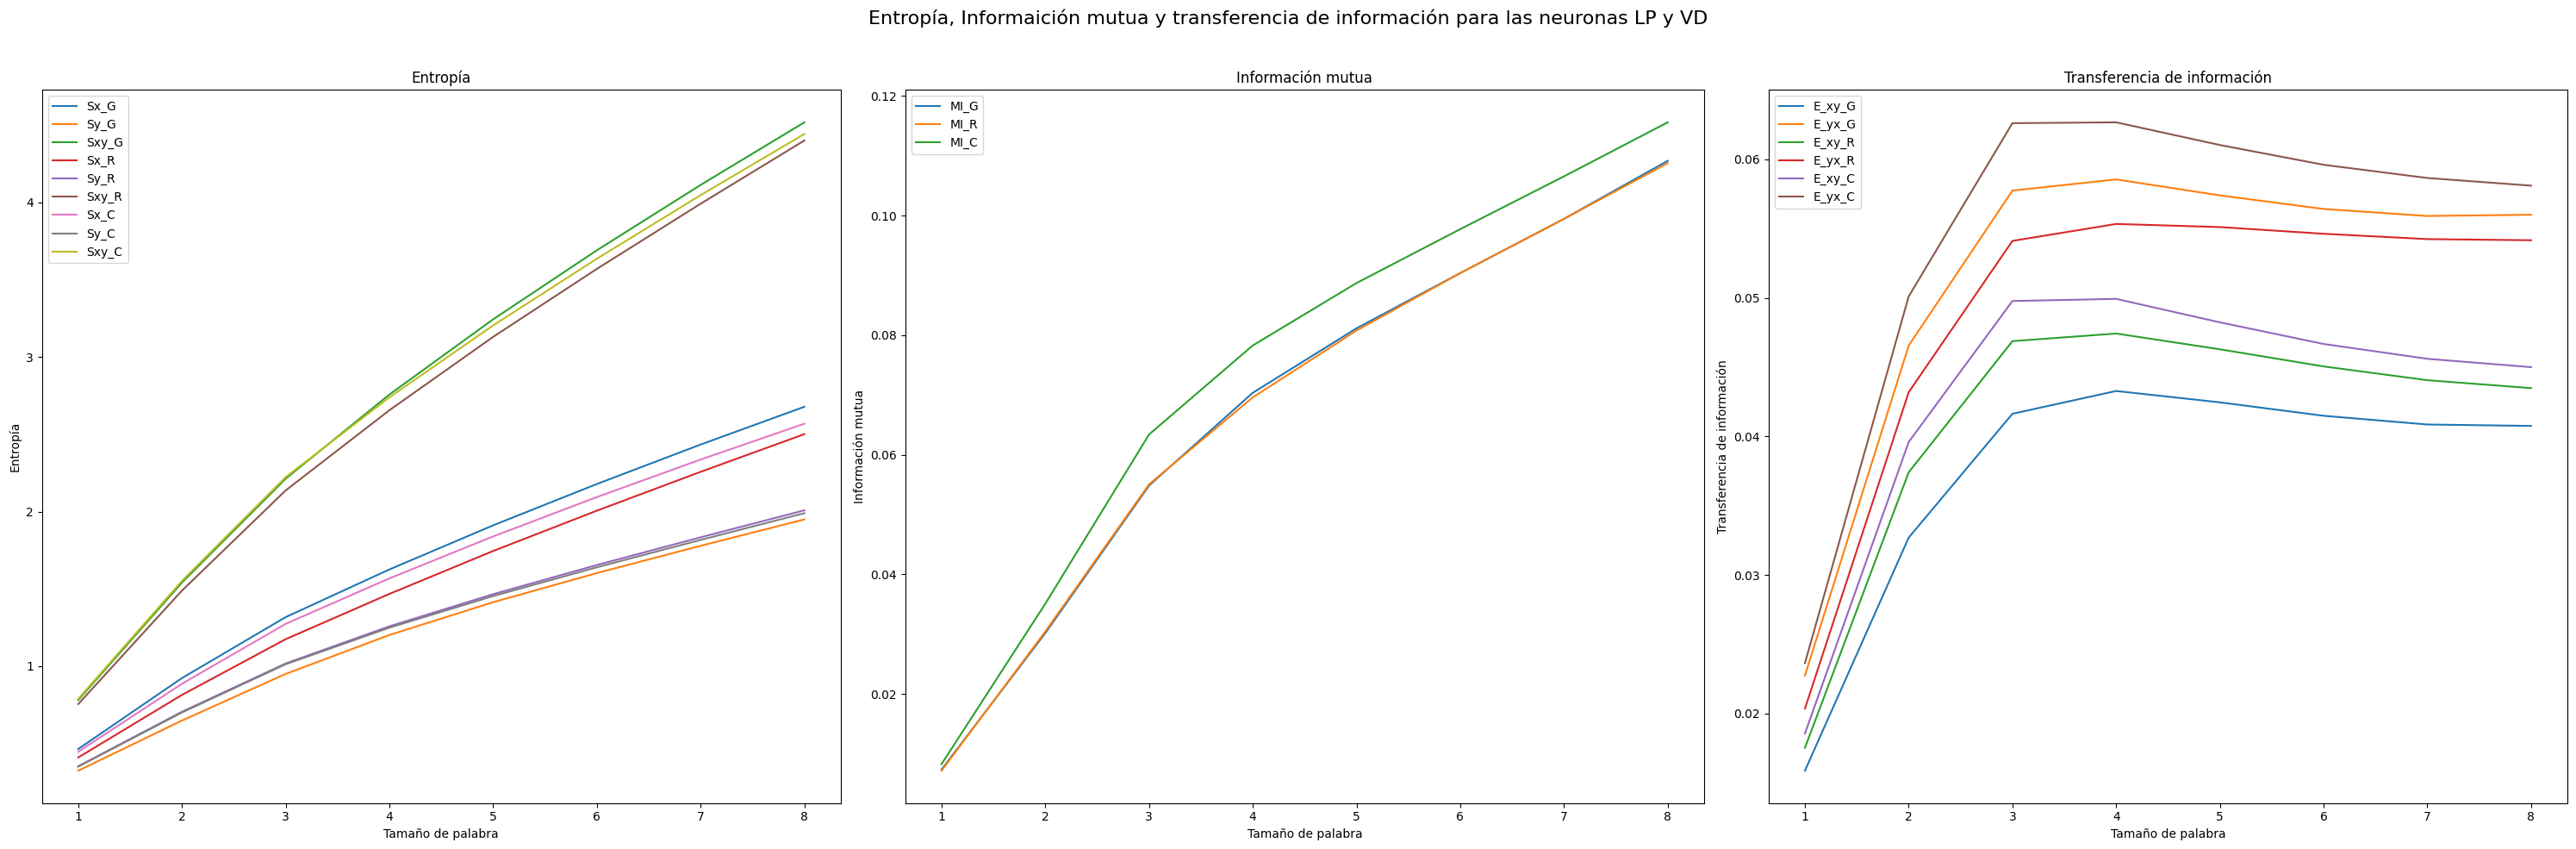

In [264]:
fig, axs = plt.subplots(1, 3, figsize=(30, 10))

# Entorpy plot
axs[0].plot(G_df.index, G_df.iloc[:, 0], label='Sx_G')
axs[0].plot(G_df.index, G_df.iloc[:, 1], label='Sy_G')
axs[0].plot(G_df.index, G_df.iloc[:, 2], label='Sxy_G')
axs[0].plot(R_df.index, R_df.iloc[:, 0], label='Sx_R')
axs[0].plot(R_df.index, R_df.iloc[:, 1], label='Sy_R')
axs[0].plot(R_df.index, R_df.iloc[:, 2], label='Sxy_R')
axs[0].plot(C_df.index, C_df.iloc[:, 0], label='Sx_C')
axs[0].plot(C_df.index, C_df.iloc[:, 1], label='Sy_C')
axs[0].plot(C_df.index, C_df.iloc[:, 2], label='Sxy_C')

axs[0].set_title('Entropía')
axs[0].set_xlabel('Tamaño de palabra')
axs[0].set_ylabel('Entropía')
axs[0].legend()

# Mutual Information plot
axs[1].plot(G_df.index, G_df.iloc[:, 3], label='MI_G')
axs[1].plot(R_df.index, R_df.iloc[:, 3], label='MI_R')
axs[1].plot(C_df.index, C_df.iloc[:, 3], label='MI_C')

axs[1].set_title('Información mutua')
axs[1].set_xlabel('Tamaño de palabra')
axs[1].set_ylabel('Información mutua') 
axs[1].legend()

# Information Transfer plot
axs[2].plot(G_df.index, G_df.iloc[:, 4], label='E_xy_G')
axs[2].plot(G_df.index, G_df.iloc[:, 5], label='E_yx_G')
axs[2].plot(R_df.index, R_df.iloc[:, 4], label='E_xy_R')
axs[2].plot(R_df.index, R_df.iloc[:, 5], label='E_yx_R')
axs[2].plot(C_df.index, C_df.iloc[:, 4], label='E_xy_C')
axs[2].plot(C_df.index, C_df.iloc[:, 5], label='E_yx_C')

axs[2].set_title('Transferencia de información') 
axs[2].set_xlabel('Tamaño de palabra')
axs[2].set_ylabel('Transferencia de información')
axs[2].legend()

fig.suptitle('Entropía, Informaición mutua y transferencia de información para las neuronas LP y VD', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()

## ANÁLISIS GRÁFICAS

### 4.2. Información mutua y transferencia de información en función del tamaño de ventana

Ahora se necesita representar la información mutua y la transferencia de información entre las neuronas en dunción del tamaño de ventana para los distintos ejemplos de tamaños de palabra que hemos observado.

Sin embargo, aquí entra en juego hasta qué tamaño de ventana se debería representar. Si escogemos ventanas demasiado grandes, una gran cantidad de información (de spikes) van a ser perdidas puesto que al escoger ventanas muy grandes (de hecho, ventanas más grandes a la que hemos seleccionado como la óptima) varias spikes caerán en la misma ventana y perderemos información. Es por eso que vamos a representar estas variables hasta que dejemos fuera las distancias entre spikes que no se encuentren en nuestro percentil del 5% más pequeñas puesto que si eligiéramos ventanas mucho más grandes, en muchas ocasiones varias spikes caerían dentro de una misma ventana lo cual deja de tener sentido para nuestra representación.

Como vamos a tener spikes duplicadas en algunas de nuestras ventanas, ahora nuestro vector de unos y ceros contendrá un uno si hay una o más spikes y tendrá un cero si no hay ninguna spike.

In [265]:
def find_max_window(df: pd.DataFrame, percentile: float) -> int:
    original_spaces_LP = get_zeros_between_spikes(df)[0]
    original_spaces_VD = get_zeros_between_spikes(df)[1]

    return original_spaces_LP[int(len(original_spaces_LP)*percentile)], original_spaces_VD[int(len(original_spaces_VD)*percentile)]

In [266]:
# Buscamos el tamaño de ventana óptimo para el trozo G
window_size_LP_G, window_size_VD_G = find_max_window(trozoG_no_outliers, 0.05)

print(f"Tamaño de ventana máximo para LP: {window_size_LP_G}")
print(f"Tamaño de ventana máximo para VD: {window_size_VD_G}")

Tamaño de ventana máximo para LP: 106
Tamaño de ventana máximo para VD: 90


Tras correrlo, vemos que se obtiene la ventana dentro del 5% es para 90 en el caso de VD y 106 en el caso de LP. Es por ello que vamos a calcular la información mutua, la transferencia de información y la entropía normalizada para los tamaños de palabra del 1 al 8 y para tamaños de ventana del 5 al 90 (si eligiéramos la ventana de 106, se perderían datos y dejaría de tener sentido para VD) para estudiar su comportamiento en función del tamaño de ventana:

In [267]:
def compute_all(trozo: pd.DataFrame, word_sizes: np.array, window_sizes = np.array) -> tuple[np.ndarray]:
    # Arrays para almacenar resultados
    mi_results = np.zeros([len(window_sizes), len(word_sizes)])
    e_xy_results = np.zeros([len(window_sizes), len(word_sizes)])
    e_yx_results = np.zeros([len(window_sizes), len(word_sizes)])
    norm_mi_results = np.zeros([len(window_sizes), len(word_sizes)])

    # Bucle para recorrer window_sizes y word_sizes
    for i, window_size in enumerate(window_sizes):
        # Reducir el dataframe para cada tamaño de ventana
        trozo_windowed = reduce_with_window(trozo, window_size)
        trozo_windowed_filtered = trozo_windowed[['LP', 'VD']]
        X, Y = get_columns_as_array(trozo_windowed_filtered)
        trozo_information = MI(X, Y, word_sizes)
    
        # Calculamos MI, E_xy, E_yx
        trozo_information.compute_MI_IT()
        trozo_df = trozo_information.get_data()

        # Guardamos los resultados de MI, E_xy y E_yx
        mi_results[i,:] = np.array(trozo_df['MI'])
        e_xy_results[i,:] = np.array(trozo_df['E_xy'])
        e_yx_results[i,:] = np.array(trozo_df['E_yx'])
        
        # Calculamos MI normalizada y guardamos
        norm_mi_results[i] = trozo_information.compute_norm_MI(window_size)

    # Guardamos los resultados
    save_object(mi_results, f'mi_results_total')
    save_object(e_xy_results, f'e_xy_results_total')
    save_object(e_yx_results, f'e_yx_results_total')
    save_object(norm_mi_results, f'norm_mi_results_total')

    return mi_results, e_xy_results, e_yx_results, norm_mi_results

In [268]:
def plot_all(window_sizes, word_sizes, mi_results, e_xy_results, e_yx_results, norm_mi_results):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    for i in range(len(word_sizes)):
        ax[0].plot(window_sizes, mi_results[:,i], label=f'Tamaño de palabra {i+1}')
        ax[0].set_title("Información mutua")
        ax[0].set_xlabel("Tamaño de ventana")
        ax[0].set_ylabel("Valor de MI")
        ax[0].legend()

        ax[1].plot(window_sizes, norm_mi_results[:,i], label=f'Tamaño de palabra {i+1}')
        ax[1].set_title("Información mutua normalizada")
        ax[1].set_xlabel("Tamaño de ventana")
        ax[1].set_ylabel("Valor de MI normalizada")
        ax[1].legend()

    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))

    for i in range(len(word_sizes)):
        row, col = divmod(i, 4)
    
        axes[row, col].plot(window_sizes, e_xy_results[:,i], label="E_xy")
        axes[row, col].plot(window_sizes, e_yx_results[:,i], label="E_yx")
    
        axes[row, col].set_title(f'Tamaño de palabra {i+1}')
        axes[row, col].set_xlabel("Tamaño de ventana")
        axes[row, col].set_ylabel("Valor de IT")
        axes[row, col].legend(loc="upper left")

    fig.suptitle('Transferencia de información')
    plt.tight_layout()
    plt.show()

In [269]:
from os.path import exists

# Definir los arrays de tamaños de palabra y ventana
word_sizes = np.arange(1, 9, 1)
window_sizes = np.arange(5, window_size_VD_G, 2)

if (exists('mi_results_total_G') and
    exists('e_xy_results_total_G') and
    exists('e_yx_results_total_G') and
    exists('norm_mi_results_total_G')):
        
    # Si todos los archivos existen, simplemente los cargamos y retornamos
    mi_results_G = load_object('mi_results_total_G')
    e_xy_results_G = load_object('e_xy_results_total_G')
    e_yx_results_G = load_object('e_yx_results_total_G')
    norm_mi_results_G = load_object('norm_mi_results_total_G')

else:
    mi_results_G, e_xy_results_G, e_yx_results_G, norm_mi_results_G = compute_all(trozoG_no_outliers, word_sizes, window_sizes)

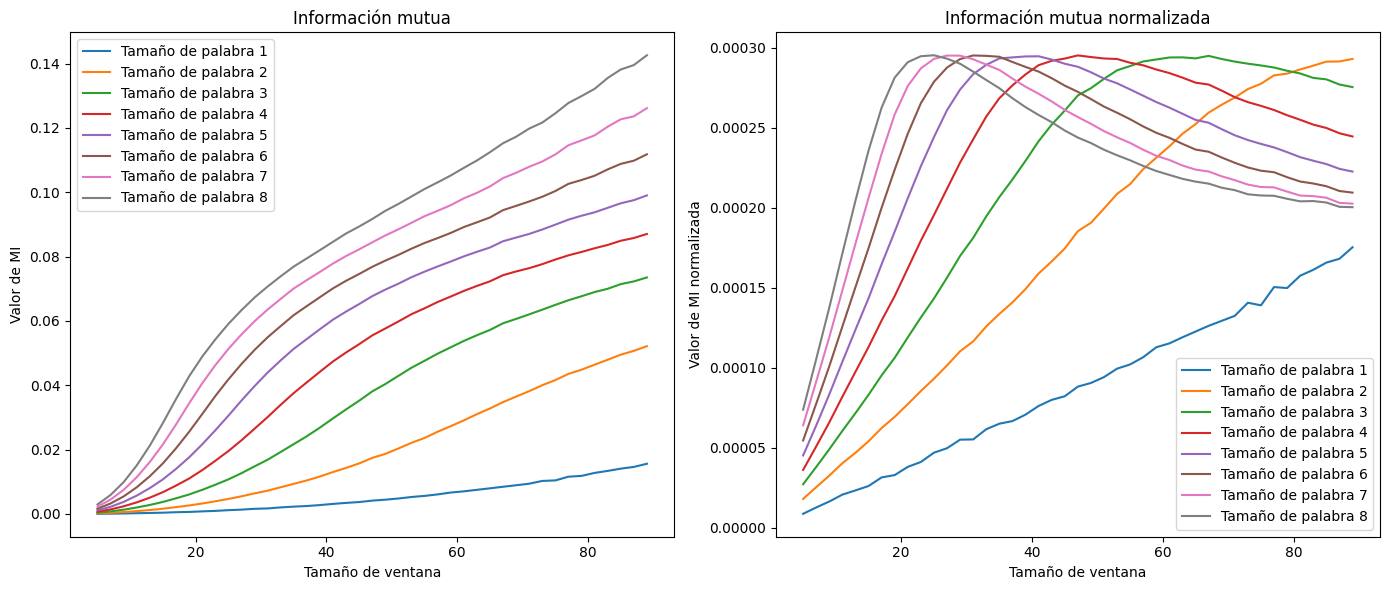

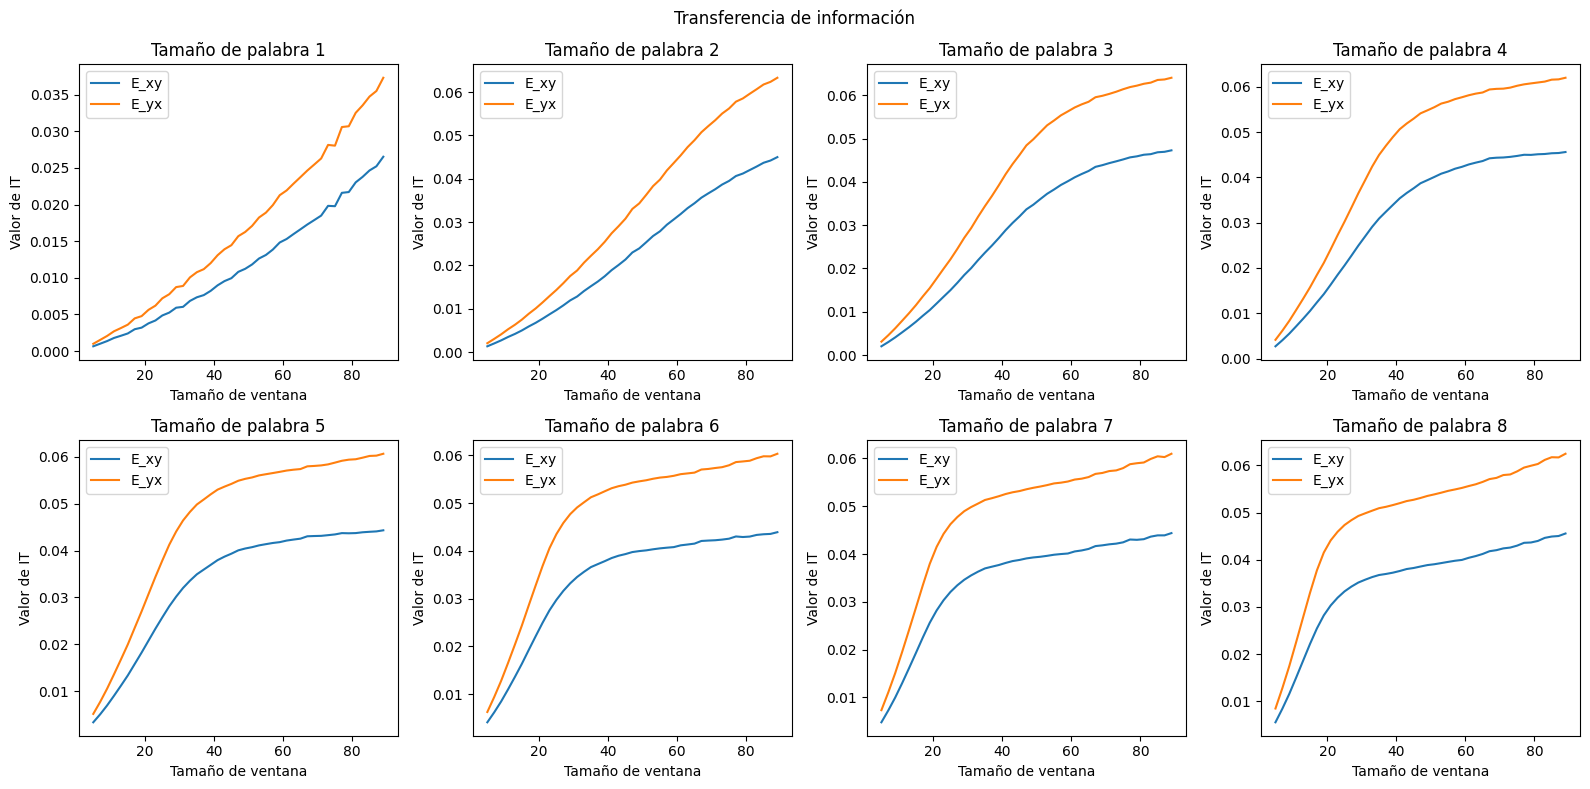

In [270]:
plot_all(window_sizes, word_sizes, mi_results_G, e_xy_results_G, e_yx_results_G, norm_mi_results_G)

## ANÁLISIS GRÁFICAS

In [271]:
# Buscamos el tamaño de ventana óptimo para el trozo C
window_size_LP_C, window_size_VD_C = find_max_window(trozoC_no_outliers, 0.05)

print(f"Tamaño de ventana máximo para LP: {window_size_LP_C}")
print(f"Tamaño de ventana máximo para VD: {window_size_VD_C}")

Tamaño de ventana máximo para LP: 107
Tamaño de ventana máximo para VD: 91


Ahora vemos que se obtiene la ventana dentro del 5% es para 97 en el caso de VD y 107 en el caso de LP. Sin embargo, para poder comparar más adelante estas variables en inyección de GABA y en control, vamos a utilizar la ventana mínima vista anteriormente de 90. Además así seremos algo más sensatos y no obtendremos tantos spikes en la misma venta para este caso:

In [272]:
# Definir los arrays de tamaños de palabra y ventana
word_sizes = np.arange(1, 9, 1)
window_sizes = np.arange(5, window_size_VD_G, 2)

if (exists('mi_results_total_C') and
    exists('e_xy_results_total_C') and
    exists('e_yx_results_total_C') and
    exists('norm_mi_results_total_C')):
        
    # Si todos los archivos existen, simplemente los cargamos y retornamos
    mi_results_C = load_object('mi_results_total_C')
    e_xy_results_C = load_object('e_xy_results_total_C')
    e_yx_results_C = load_object('e_yx_results_total_C')
    norm_mi_results_C = load_object('norm_mi_results_total_C')

else:
    mi_results_C, e_xy_results_C, e_yx_results_C, norm_mi_results_C = compute_all(trozoC_no_outliers, word_sizes, window_sizes)

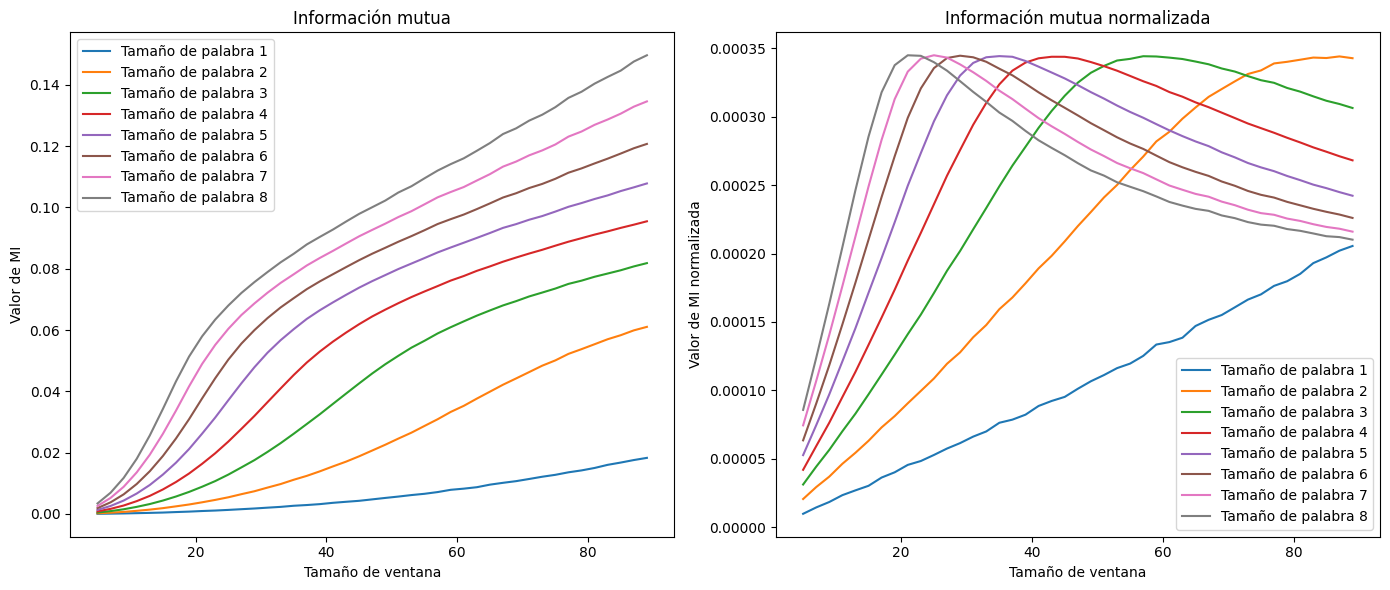

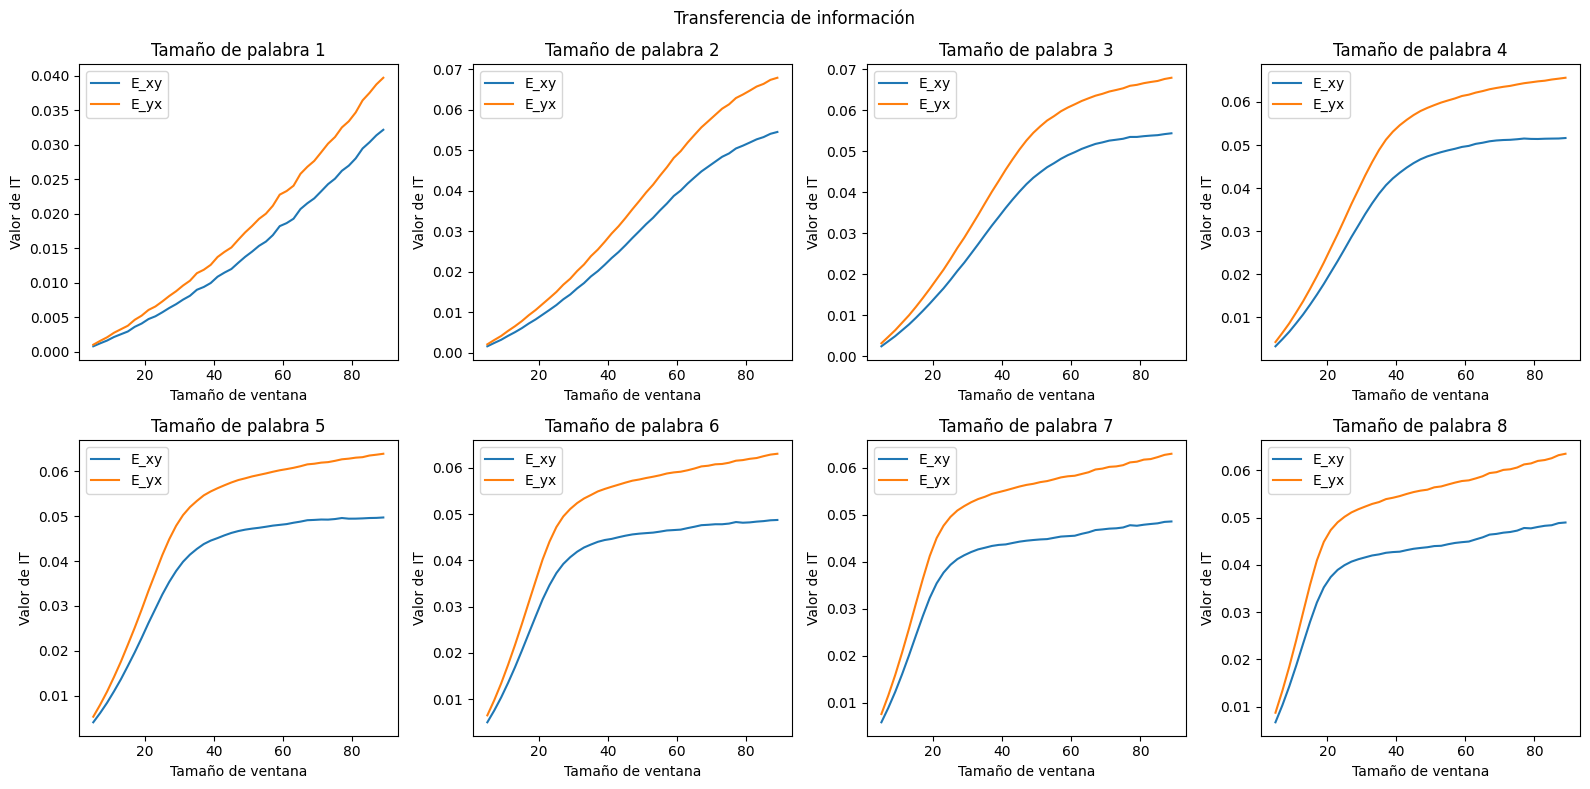

In [273]:
plot_all(window_sizes, word_sizes, mi_results_C, e_xy_results_C, e_yx_results_C, norm_mi_results_C)

In [274]:
# Buscamos el tamaño de ventana óptimo para el trozo R
window_size_LP_R, window_size_VD_R = find_max_window(trozoR_no_outliers, 0.05)

print(f"Tamaño de ventana máximo para LP: {window_size_LP_R}")
print(f"Tamaño de ventana máximo para VD: {window_size_VD_R}")

Tamaño de ventana máximo para LP: 108
Tamaño de ventana máximo para VD: 90


Ahora vemos que se obtiene la ventana dentro del 5% es para 90 en el caso de VD y 108 en el caso de LP. Ahora para poder comparar más adelante estas variables en inyección de GABA en control y en reposo, debemos a utilizar la ventana mínima vista anteriormente de 90 (y obtenida ahora también casualmente). Así podremos compararlos fácilmente:

In [275]:
# Definir los arrays de tamaños de palabra y ventana
word_sizes = np.arange(1, 9, 1)
window_sizes = np.arange(5, window_size_VD_R, 2)

if (exists('mi_results_total_R') and
    exists('e_xy_results_total_R') and
    exists('e_yx_results_total_R') and
    exists('norm_mi_results_total_R')):
        
    # Si todos los archivos existen, simplemente los cargamos y retornamos
    mi_results_R = load_object('mi_results_total_R')
    e_xy_results_R = load_object('e_xy_results_total_R')
    e_yx_results_R = load_object('e_yx_results_total_R')
    norm_mi_results_R = load_object('norm_mi_results_total_R')

else:
    mi_results_R, e_xy_results_R, e_yx_results_R, norm_mi_results_R = compute_all(trozoR_no_outliers, word_sizes, window_sizes)

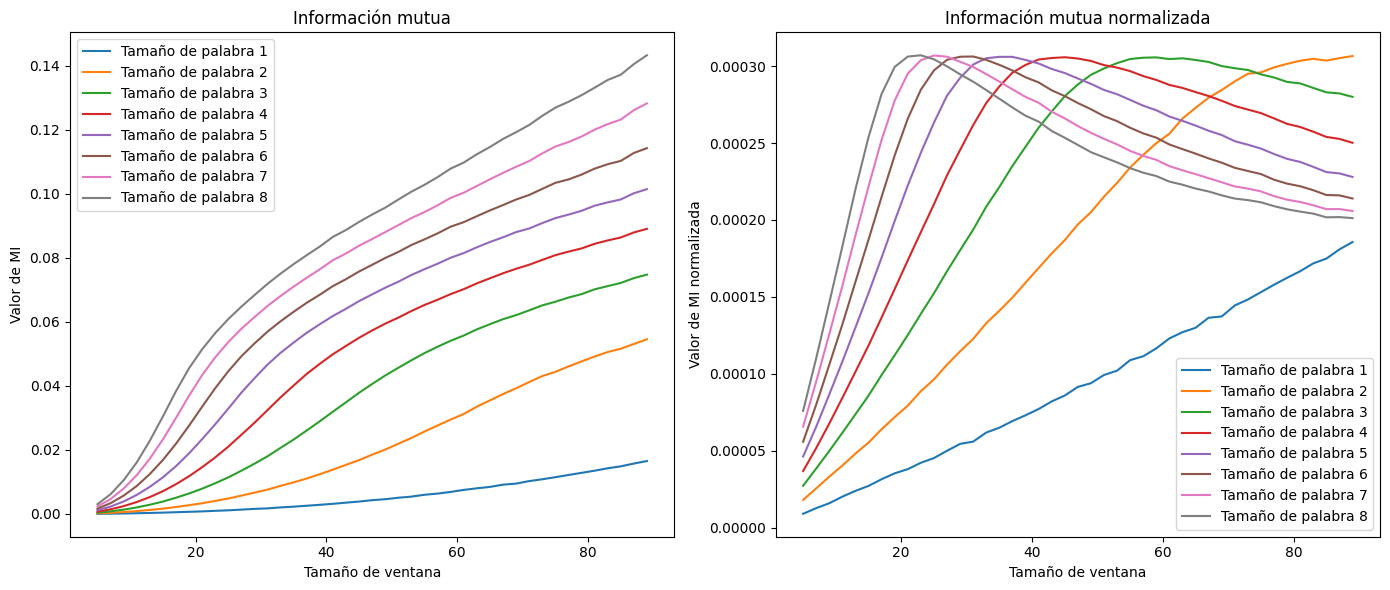

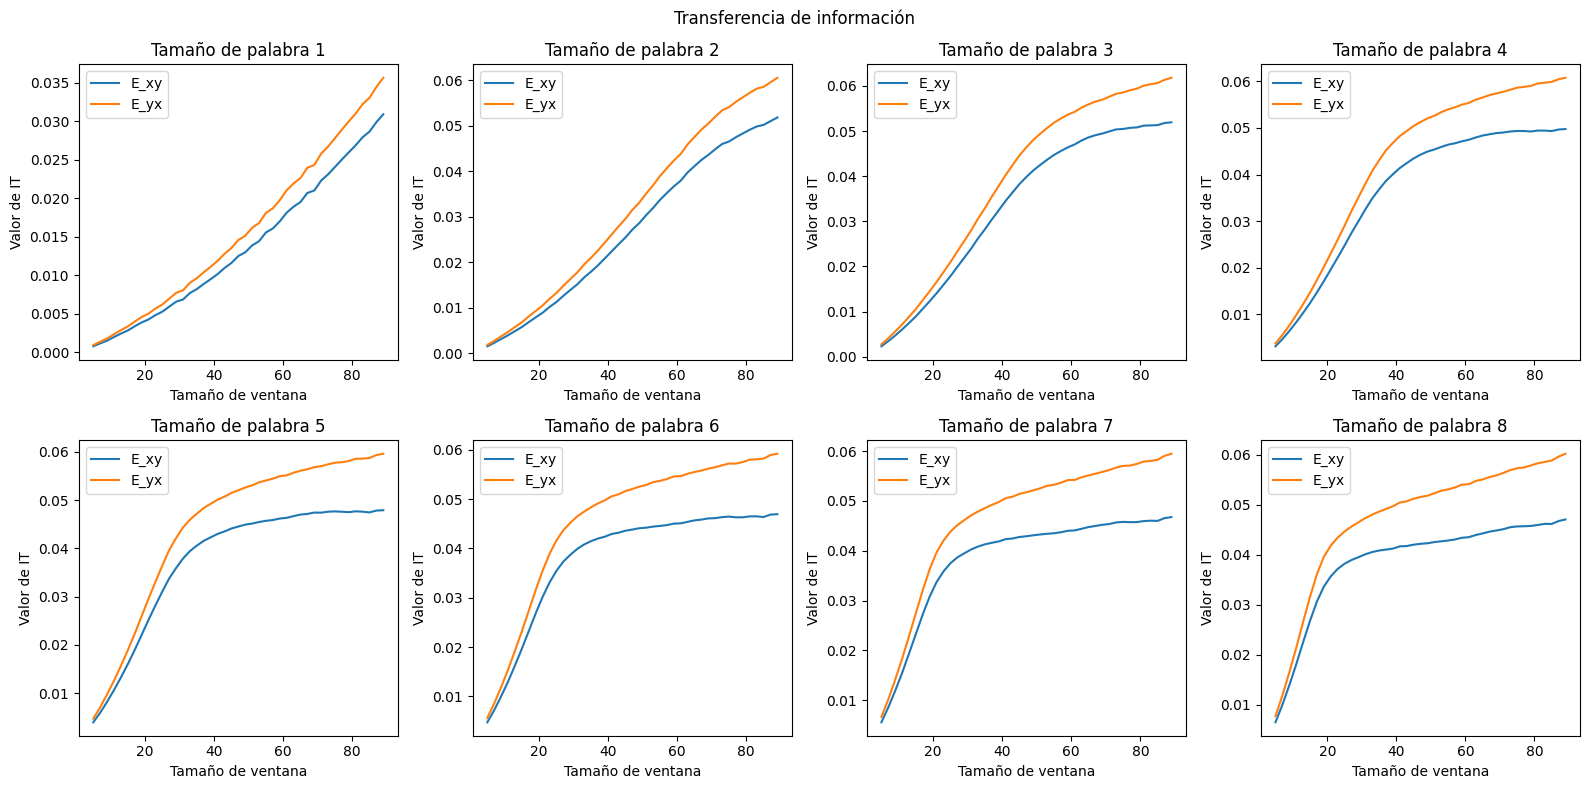

In [276]:
plot_all(window_sizes, word_sizes, mi_results_R, e_xy_results_R, e_yx_results_R, norm_mi_results_R)

## ANÁLISIS GRÁFICAS

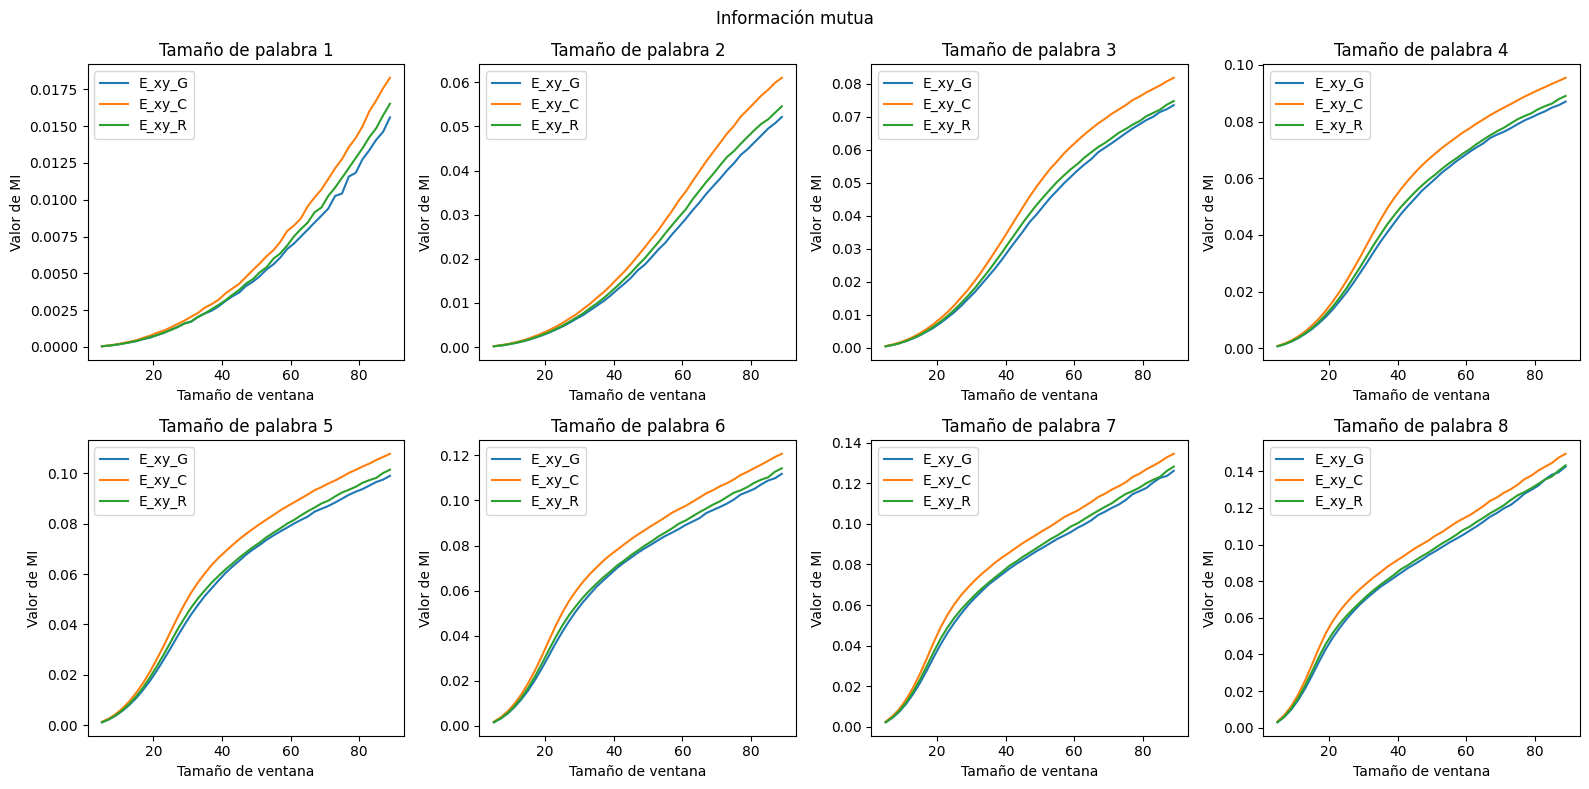

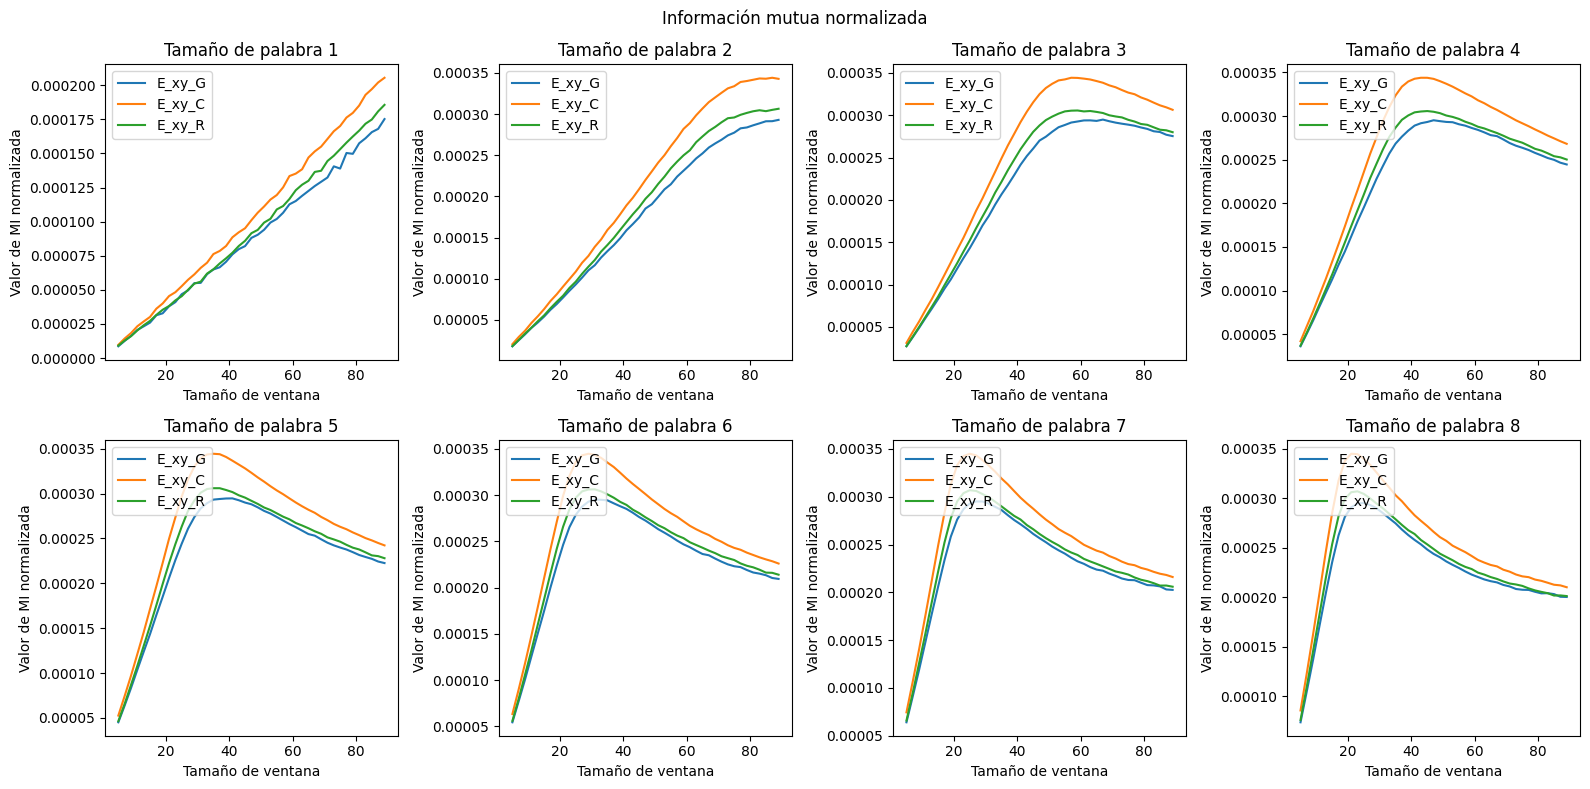

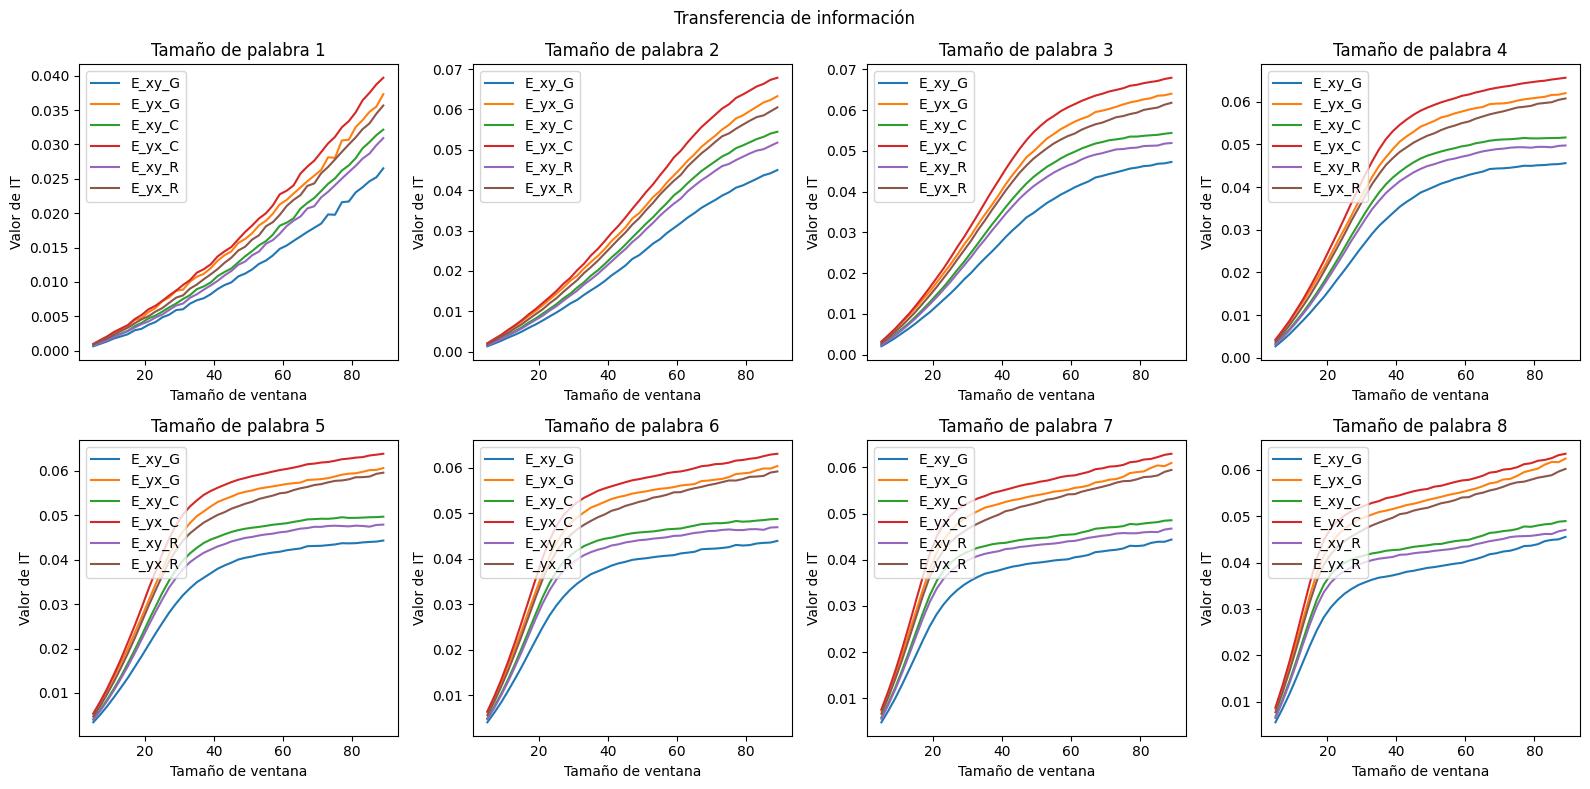

In [277]:
# Información mutua
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i in range(len(word_sizes)):
    row, col = divmod(i, 4)
    
    axes[row, col].plot(window_sizes, mi_results_G[:,i], label="E_xy_G")
    axes[row, col].plot(window_sizes, mi_results_C[:,i], label="E_xy_C")
    axes[row, col].plot(window_sizes, mi_results_R[:,i], label="E_xy_R")
    
    axes[row, col].set_title(f'Tamaño de palabra {i+1}')
    axes[row, col].set_xlabel("Tamaño de ventana")
    axes[row, col].set_ylabel("Valor de MI")
    axes[row, col].legend(loc="upper left")

fig.suptitle('Información mutua')
plt.tight_layout()
plt.show()

# Información mutua normalizada
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i in range(len(word_sizes)):
    row, col = divmod(i, 4)
    
    axes[row, col].plot(window_sizes, norm_mi_results_G[:,i], label="E_xy_G")
    axes[row, col].plot(window_sizes, norm_mi_results_C[:,i], label="E_xy_C")
    axes[row, col].plot(window_sizes, norm_mi_results_R[:,i], label="E_xy_R")
    
    axes[row, col].set_title(f'Tamaño de palabra {i+1}')
    axes[row, col].set_xlabel("Tamaño de ventana")
    axes[row, col].set_ylabel("Valor de MI normalizada")
    axes[row, col].legend(loc="upper left")

fig.suptitle('Información mutua normalizada')
plt.tight_layout()
plt.show()

# Transferencia de información
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i in range(len(word_sizes)):
    row, col = divmod(i, 4)
    
    axes[row, col].plot(window_sizes, e_xy_results_G[:,i], label="E_xy_G")
    axes[row, col].plot(window_sizes, e_yx_results_G[:,i], label="E_yx_G")
    axes[row, col].plot(window_sizes, e_xy_results_C[:,i], label="E_xy_C")
    axes[row, col].plot(window_sizes, e_yx_results_C[:,i], label="E_yx_C")
    axes[row, col].plot(window_sizes, e_xy_results_R[:,i], label="E_xy_R")
    axes[row, col].plot(window_sizes, e_yx_results_R[:,i], label="E_yx_R")
    
    axes[row, col].set_title(f'Tamaño de palabra {i+1}')
    axes[row, col].set_xlabel("Tamaño de ventana")
    axes[row, col].set_ylabel("Valor de IT")
    axes[row, col].legend(loc="upper left")

fig.suptitle('Transferencia de información')
plt.tight_layout()
plt.show()

## ANÁLISIS GRÁFICAS

## 5. Representación de SAX